# Project: Analysis of Developer Social Networks

This notebook analyzes the social networks of developers who starred popular
**machine learning** or **web development** repositories (with at least 10 stars)
up to August 2019. Each network is a largest component of at least 10 users.

**Nodes**: Developer (user) accounts.
**Edges**: Undirected (follower relationships).
**Labels**: Binary (0 = Web dev, 1 = ML dev).

The goal is to **decide** whether a network belongs to **web** or **ML** developers.
Below we:
- Load data from `git_edges.json` (dictionary of graphs) and `git_target` (labels).
- Inspect basic statistics (histograms, distributions).
- Extract structural features for classification.
- Perform a community detection experiment.
- Compare Node2Vec vs. spectral embeddings.

## 1. Imports and Setup

In [66]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from networkx.algorithms import community
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import igraph as ig
import leidenalg
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


try:
    import community as community_louvain
except ImportError:
    print("Install python-louvain for Louvain: pip install python-louvain")

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict

## 2. Load Data (from dictionary-format JSON)
Here, we load JSON where each key is a graph ID and the value is a list of edges.
Then, we align these graphs with a target CSV specifying whether each graph
belongs to web (0) or ML (1).

In [67]:
# Load the JSON file
with open('github_stargazers/git_edges.json', 'r') as f:
    full_data = json.load(f)

# Sort keys and extract edge lists for ALL graphs
sorted_keys = sorted(full_data.keys(), key=int)
edge_lists = [full_data[k] for k in sorted_keys]

# Load the CSV file
targets_df = pd.read_csv('github_stargazers/git_target.csv', index_col=0)

# Extract ALL labels
labels = [targets_df.loc[int(k), "target"] for k in sorted_keys]

print(f"Loaded {len(edge_lists)} graphs")
print("Example graph:", edge_lists[0][:5])


Loaded 12725 graphs
Example graph: [[0, 16], [1, 16], [2, 16], [3, 16], [3, 19]]


## 3. Convert to NetworkX Graphs
We parse each edge list into an undirected NetworkX Graph.

In [68]:
graphs = []
for edges in tqdm(edge_lists):
    G = nx.Graph()
    valid_edges = [tuple(e) for e in edges if len(e) >= 2]
    G.add_edges_from(valid_edges)
    graphs.append(G)

print(f"First graph: {graphs[0].number_of_nodes()} nodes, {graphs[0].number_of_edges()} edges")

100%|██████████| 12725/12725 [00:08<00:00, 1479.64it/s]

First graph: 71 nodes, 78 edges


## 4. Dataset Statistics
Basic stats about all loaded graphs.

In [69]:
num_nodes = [g.number_of_nodes() for g in graphs]
num_edges = [g.number_of_edges() for g in graphs]
densities = [nx.density(g) for g in graphs]

print("# Nodes:", np.min(num_nodes), "to", np.max(num_nodes))
print("# Edges:", np.min(num_edges), "to", np.max(num_edges))
print("Density:", round(np.mean(densities), 4))

label_counts = pd.Series(labels).value_counts()
print("\nLabel distribution:")
print(label_counts)

# Nodes: 10 to 957
# Edges: 9 to 4668
Density: 0.0781

Label distribution:
1    6808
0    5917
Name: count, dtype: int64


## 5. Visualize Sample Graphs
We'll show a few example graphs from each label category (web=0, ml=1).


Sample graphs for label 0:


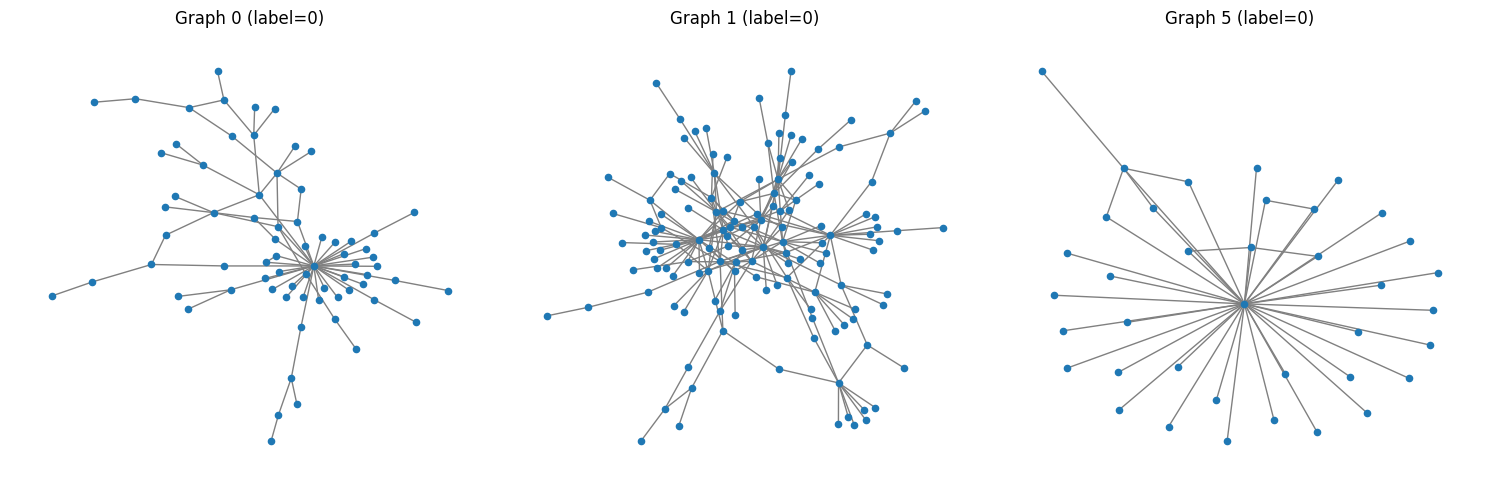


Sample graphs for label 1:


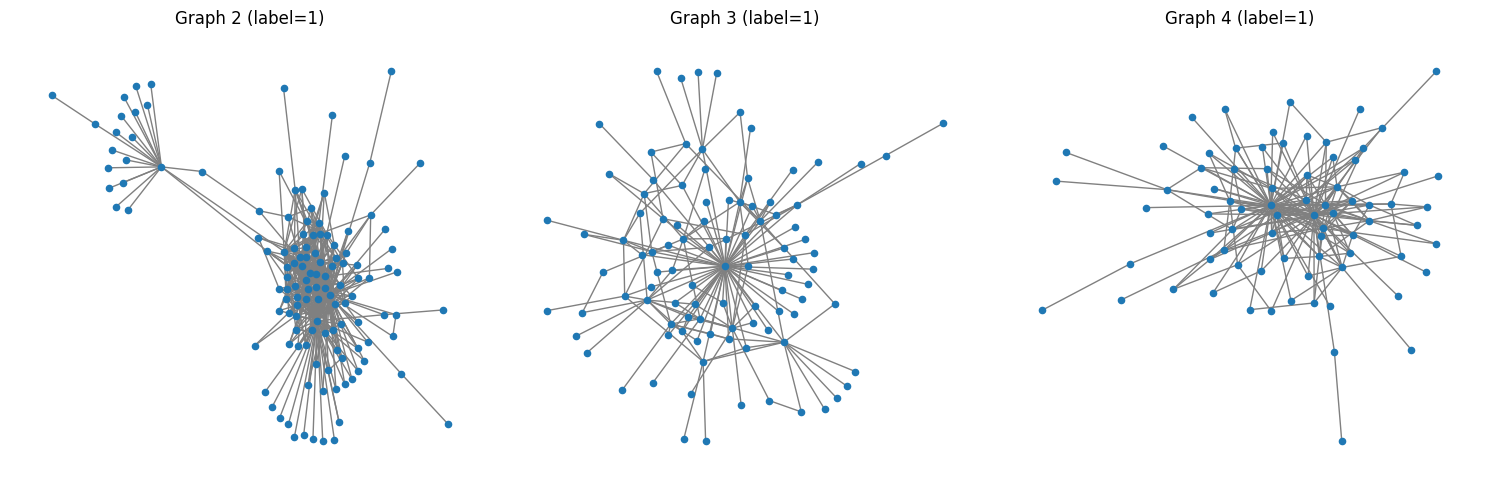

In [70]:
def plot_graph(g, ax, title):
    pos = nx.spring_layout(g, seed=42)
    nx.draw(g, pos, node_size=20, edge_color='gray', ax=ax)
    ax.set_title(title)
    ax.axis('off')

# Show 3 graphs from each class in a subplot layout
for label in [0, 1]:
    print(f"\nSample graphs for label {label}:")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    count = 0
    for i, g in enumerate(graphs):
        if labels[i] == label:
            plot_graph(g, axes[count], f"Graph {i} (label={label})")
            count += 1
            if count == 3:
                break
    plt.tight_layout()
    plt.show()


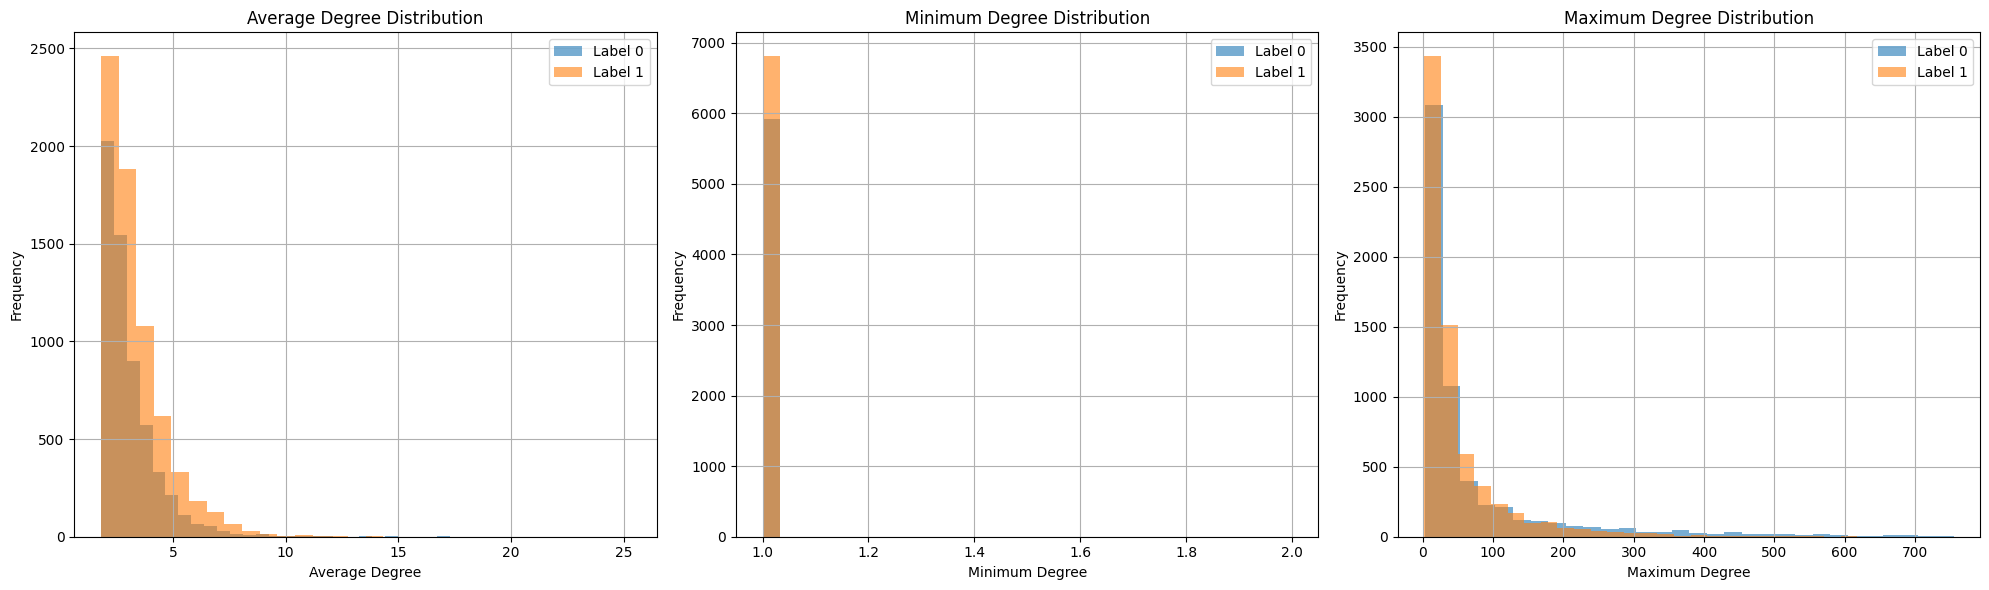

In [71]:
# Organize statistics by label
avg_degree_by_label = {0: [], 1: []}
min_degree_by_label = {0: [], 1: []}
max_degree_by_label = {0: [], 1: []}

# Collect degree statistics
for i, g in enumerate(graphs):
    label = labels[i]
    degrees = [g.degree(n) for n in g.nodes()]
    
    avg_degree_by_label[label].append(np.mean(degrees))
    min_degree_by_label[label].append(np.min(degrees))
    max_degree_by_label[label].append(np.max(degrees))

# Comparative plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Side-by-side histograms by label
axes[0].hist(avg_degree_by_label[0], bins=30, alpha=0.6, label='Label 0')
axes[0].hist(avg_degree_by_label[1], bins=30, alpha=0.6, label='Label 1')
axes[0].set_title("Average Degree Distribution")
axes[0].set_xlabel("Average Degree")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)

axes[1].hist(min_degree_by_label[0], bins=30, alpha=0.6, label='Label 0')
axes[1].hist(min_degree_by_label[1], bins=30, alpha=0.6, label='Label 1')
axes[1].set_title("Minimum Degree Distribution")
axes[1].set_xlabel("Minimum Degree")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(True)

axes[2].hist(max_degree_by_label[0], bins=30, alpha=0.6, label='Label 0')
axes[2].hist(max_degree_by_label[1], bins=30, alpha=0.6, label='Label 1')
axes[2].set_title("Maximum Degree Distribution")
axes[2].set_xlabel("Maximum Degree")
axes[2].set_ylabel("Frequency")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


# Analysis

Degree Distribution

- Average Degree: Most graphs have a low average degree, indicating sparse connectivity.
- Minimum Degree: Nearly all graphs have nodes with a minimum degree of 1, showing peripheral connections.
- Maximum Degree: Some graphs contain hubs with very high degrees, influencing network structure.

Network Characteristics:

- Sparse Connectivity: Most networks are sparsely connected with few highly connected nodes.
- Hubs Presence: A few networks have nodes with many connections, acting as central points.



## Clustering coefficient (CC)

The **local clustering coefficient** of a node \( v \) measures how close its neighbors are to forming a complete subgraph (i.e., how many triangles involve \( v \)).

It is defined as:

$$
c_v = \frac{|\{(v,u), (u,w), (w,v) \in E\}|}{\frac{1}{2} d_v(d_v - 1)}
$$

- $d_v$ : degree of node $v$ (number of neighbors)
- $E$: set of edges in the graph
- The numerator counts the number of **triangles** involving $v$ and its neighbors
- The denominator is the **maximum number of possible links** between $v$'s neighbors

If $d_v < 2$, then $c_v = 0$.



Clustering Coefficient (average per graph):
Label 0 -> Mean: 0.1882, Std Dev: 0.1351
Label 1 -> Mean: 0.1943, Std Dev: 0.1193


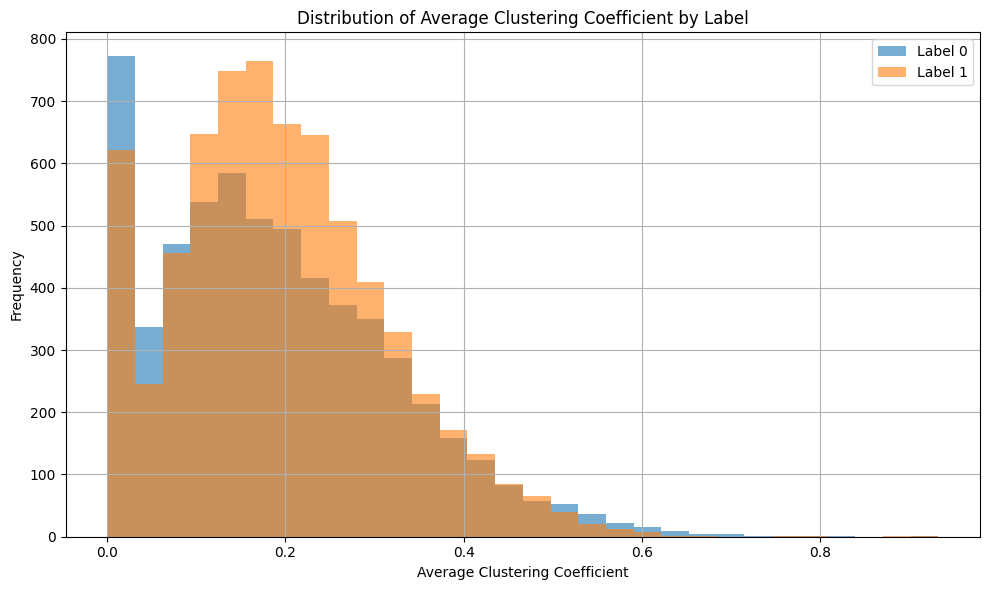

In [72]:
# Dictionaries to store clustering coefficients by label
cc_by_label = {0: [], 1: []}

# Calculating the average clustering coefficient for each graph
for i, g in enumerate(graphs):
    label = labels[i]
    cc = nx.average_clustering(g)
    cc_by_label[label].append(cc)

# Basic statistics
print("Clustering Coefficient (average per graph):")
print(f"Label 0 -> Mean: {np.mean(cc_by_label[0]):.4f}, Std Dev: {np.std(cc_by_label[0]):.4f}")
print(f"Label 1 -> Mean: {np.mean(cc_by_label[1]):.4f}, Std Dev: {np.std(cc_by_label[1]):.4f}")

# Comparative histogram
plt.figure(figsize=(10, 6))
plt.hist(cc_by_label[0], bins=30, alpha=0.6, label='Label 0')
plt.hist(cc_by_label[1], bins=30, alpha=0.6, label='Label 1')
plt.title("Distribution of Average Clustering Coefficient by Label")
plt.xlabel("Average Clustering Coefficient")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Selection of Graphs for Detailed Analysis

Our dataset contains a large number of graphs, each varying in size and structure. However, during initial exploration, we observed that many of these graphs share very similar topological profiles, despite being labeled as either class 0 or 1. This structural similarity makes it challenging to distinguish them based solely on visual inspection or basic graph statistics.

To conduct a more focused and meaningful analysis, we select two representative graphs based on structural extremities:

- Graph with the highest number of nodes

- Graph with the highest number of edges

In [73]:
max_nodes = 0
max_edges = 0
graph_with_most_nodes = -1
graph_with_most_edges = -1

for i, edges in enumerate(edge_lists):
    # extrai todos os nós únicos daquele grafo
    node_ids = set([n for edge in edges for n in edge])
    num_nodes = len(node_ids)
    num_edges = len(edges)

    if num_nodes > max_nodes:
        max_nodes = num_nodes
        graph_with_most_nodes = i

    if num_edges > max_edges:
        max_edges = num_edges
        graph_with_most_edges = i

print(f"Graph with most NODES: ID {graph_with_most_nodes}, {max_nodes} nodes")
print(f"Graphs with most EDGES: ID {graph_with_most_edges}, {max_edges} edges")

graph_most_nodes = graphs[graph_with_most_nodes]
graph_most_edges = graphs[graph_with_most_edges]




Graph with most NODES: ID 1408, 957 nodes
Graphs with most EDGES: ID 5058, 4668 edges


## 6. Graph Centralities
Below, we demonstrate an in-depth look at various centrality measures on **one**
selected graph (the first). Centrality measures indicate which nodes (in this
developer network) are most influential.

- **Degree Centrality**: Nodes with many direct connections.
- **Betweenness Centrality**: Nodes bridging different parts of the network.
- **Closeness Centrality**: Nodes quickly reaching others via short paths.
- **Eigenvector Centrality**: Nodes connected to other highly important nodes.
- **Katz & PageRank**  add indirect effects or directional flow.


In [74]:
# Pick a single graph to analyze
graph_most_nodes = graphs[graph_with_most_nodes]   # ID 1408
graph_most_edges = graphs[graph_with_most_edges]   # ID 5058

sample_index = 0
sample_graph = graphs[sample_index]
print(f"Graph {sample_index} has {sample_graph.number_of_nodes()} nodes, {sample_graph.number_of_edges()} edges.")

# Helper to print top 5 nodes for any centrality measure
def print_top_5(centrality, name):
    sorted_c = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 nodes for {name}:")
    for node, val in sorted_c[:5]:
        print(f"Node: {node}, {name}: {val:.4f}")
    print()

# Helper to plot distribution
def plot_centrality_distribution(centrality, name):
    plt.figure(figsize=(10, 5))
    plt.hist(centrality.values(), bins=50, color='blue', alpha=0.7)
    plt.title(f'{name} Distribution')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Graph 0 has 71 nodes, 78 edges.


# 6.1 Degree Centrality


### Degree Centrality
Degree centrality is a measure that quantifies the importance of a node in a network based on the number of direct connections (edges) it has. In the context of your drug interaction network, a drug with high degree centrality interacts with many other drugs, suggesting that it may have a high potential for drug-drug interactions.

#### Mathematical Representation

Let $ G = (V, E) $ be an undirected graph where:

- $ V $ is the set of nodes (drugs)
- $ E $ is the set of edges (drug interactions)

The degree centrality $ C_D(v) $ of a node $ v $ is defined as:

$
C_D(v) = d(v) = \sum_{u \in V} A_{vu}
$

where $ A $ is the adjacency matrix, and $ A_{vu} = 1 $ if there is an edge between $ v $ and $ u $, otherwise $ A_{vu} = 0 $.


Top 5 nodes for Degree Centrality (Most Nodes):
Node: 448, Degree Centrality (Most Nodes): 0.3326
Node: 824, Degree Centrality (Most Nodes): 0.2762
Node: 586, Degree Centrality (Most Nodes): 0.2646
Node: 499, Degree Centrality (Most Nodes): 0.1579
Node: 529, Degree Centrality (Most Nodes): 0.1224

Top 5 nodes for Degree Centrality (Most Edges):
Node: 57, Degree Centrality (Most Edges): 0.3825
Node: 347, Degree Centrality (Most Edges): 0.3602
Node: 508, Degree Centrality (Most Edges): 0.2854
Node: 68, Degree Centrality (Most Edges): 0.2222
Node: 855, Degree Centrality (Most Edges): 0.1591



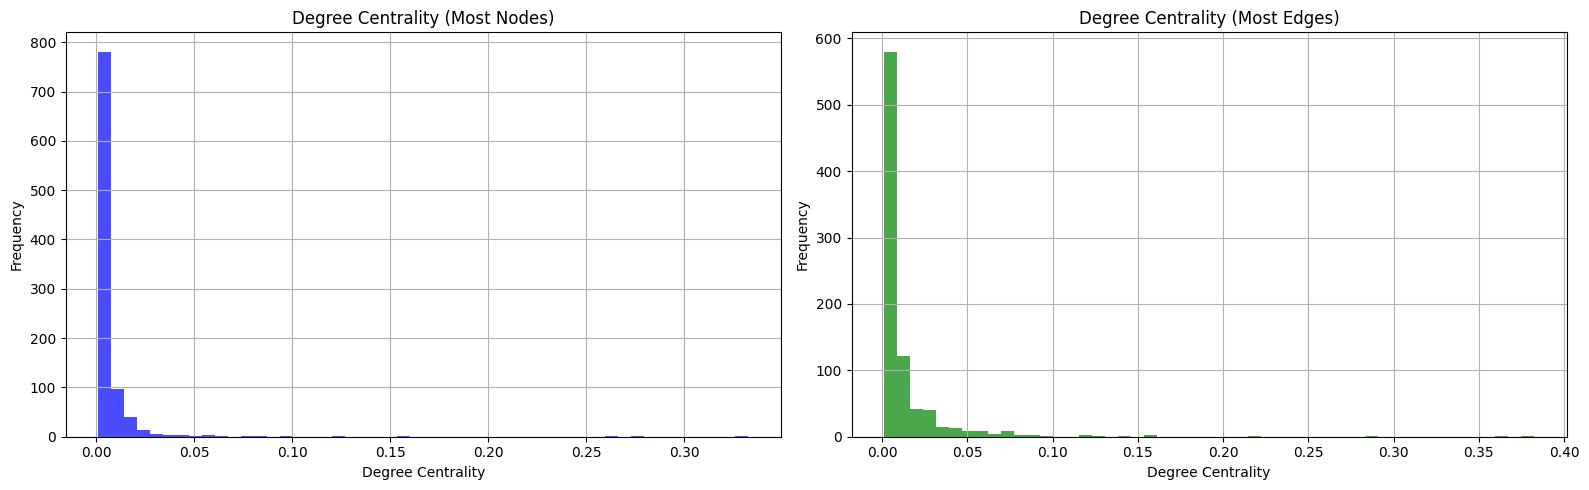

In [75]:
# Degree Centrality
degree_nodes = nx.degree_centrality(graph_most_nodes)
degree_edges = nx.degree_centrality(graph_most_edges)

# Print top 5
print_top_5(degree_nodes, "Degree Centrality (Most Nodes)")
print_top_5(degree_edges, "Degree Centrality (Most Edges)")

# Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(degree_nodes.values(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Degree Centrality (Most Nodes)')
axs[0].set_xlabel('Degree Centrality')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].hist(degree_edges.values(), bins=50, color='green', alpha=0.7)
axs[1].set_title('Degree Centrality (Most Edges)')
axs[1].set_xlabel('Degree Centrality')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Analysis

The histograms above show the degree centrality distributions for:

- Graph with the most nodes (ID 1408) – Left

- Graph with the most edges (ID 5058) – Right

Despite differences in size both graphs exhibit highly similar degree centrality profiles:

- The majority of nodes have very low degree centrality, indicating that most nodes are weakly connected.

- A small number of nodes show moderate to high centrality, acting as hubs or structurally important nodes.

The distributions are right-skewed, which is typical in real-world and scale-free networks.

This similarity suggests that, structurally, both graphs are organized in a hub-and-spoke pattern, with a few influential nodes and many peripheral ones. This aligns with common behavior in social or collaboration networks.


# 6.2 Betweenness Centrality


It measures how often a node appears on the shortest paths between other nodes. It is defined as:

$
C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$

where:
- $ \sigma_{st} $ is the total number of shortest paths between nodes $ s $ and $ t $.
- $ \sigma_{st}(v) $ is the number of those shortest paths that pass through node $ v $.

# Insights
- Nodes with high betweenness are crucial for the flow of information across the network—they serve as bottlenecks or bridges.
- Nodes with low betweenness are typically located in densely connected communities, where many alternative paths exist.


Top 5 nodes for Betweenness Centrality (Most Nodes):
Node: 448, Betweenness Centrality (Most Nodes): 0.2807
Node: 586, Betweenness Centrality (Most Nodes): 0.2323
Node: 824, Betweenness Centrality (Most Nodes): 0.2030
Node: 529, Betweenness Centrality (Most Nodes): 0.0991
Node: 499, Betweenness Centrality (Most Nodes): 0.0768

Top 5 nodes for Betweenness Centrality (Most Edges):
Node: 347, Betweenness Centrality (Most Edges): 0.2520
Node: 57, Betweenness Centrality (Most Edges): 0.2217
Node: 508, Betweenness Centrality (Most Edges): 0.1632
Node: 68, Betweenness Centrality (Most Edges): 0.1010
Node: 855, Betweenness Centrality (Most Edges): 0.0453



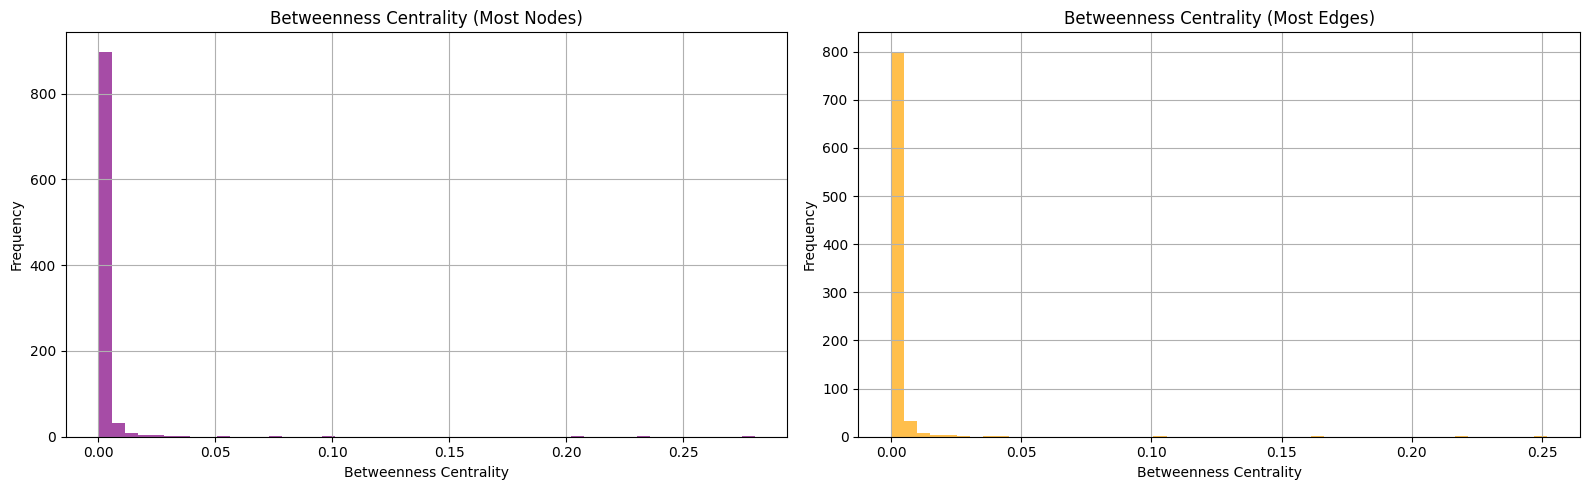

In [76]:
# Compute betweenness centrality for both graphs
betweenness_nodes = nx.betweenness_centrality(graph_most_nodes)
betweenness_edges = nx.betweenness_centrality(graph_most_edges)

# Print top 5 nodes
print_top_5(betweenness_nodes, "Betweenness Centrality (Most Nodes)")
print_top_5(betweenness_edges, "Betweenness Centrality (Most Edges)")

# Plot distributions side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(betweenness_nodes.values(), bins=50, color='purple', alpha=0.7)
axs[0].set_title('Betweenness Centrality (Most Nodes)')
axs[0].set_xlabel('Betweenness Centrality')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].hist(betweenness_edges.values(), bins=50, color='orange', alpha=0.7)
axs[1].set_title('Betweenness Centrality (Most Edges)')
axs[1].set_xlabel('Betweenness Centrality')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Analysis

Both distributions are heavily right-skewed, with most nodes having a betweenness centrality close to 0.

- A small subset of nodes exhibits high betweenness, indicating their key role in connecting different parts of the graph (acting as bridges or bottlenecks).

- The shape and pattern of both distributions are remarkably similar, reinforcing the idea that these graphs—despite differing in size—have a comparable internal structure.

This similarity supports earlier findings from degree centrality, suggesting that both graphs follow a core-periphery or hub-based structure.


# 6.3 Closeness Centrality


### Closeness Centrality

Measures how close a node is to all other nodes in the graph. It is defined as the reciprocal of the sum of the shortest path distances from a node to all other reachable nodes.

$
C_C(v) = \frac{1}{\sum_{u \neq v} d(v, u)}
$

where:
- $ d(v, u) $ is the shortest path distance between node $ v $ and node $ u $.
- A **higher** closeness centrality means a node is **more central**, as it has shorter paths to all other nodes.
  
## Interpretation
- Nodes with high closeness centrality can reach all other nodes quickly—they are typically at the center of the network.
- Nodes with low closeness are located farther from the rest of the graph, often on the periphery.




Top 5 nodes for Closeness Centrality (Most Nodes):
Node: 448, Closeness Centrality (Most Nodes): 0.5259
Node: 586, Closeness Centrality (Most Nodes): 0.5224
Node: 824, Closeness Centrality (Most Nodes): 0.4982
Node: 529, Closeness Centrality (Most Nodes): 0.4759
Node: 499, Closeness Centrality (Most Nodes): 0.4709

Top 5 nodes for Closeness Centrality (Most Edges):
Node: 57, Closeness Centrality (Most Edges): 0.5938
Node: 347, Closeness Centrality (Most Edges): 0.5897
Node: 508, Closeness Centrality (Most Edges): 0.5556
Node: 68, Closeness Centrality (Most Edges): 0.5405
Node: 855, Closeness Centrality (Most Edges): 0.5141



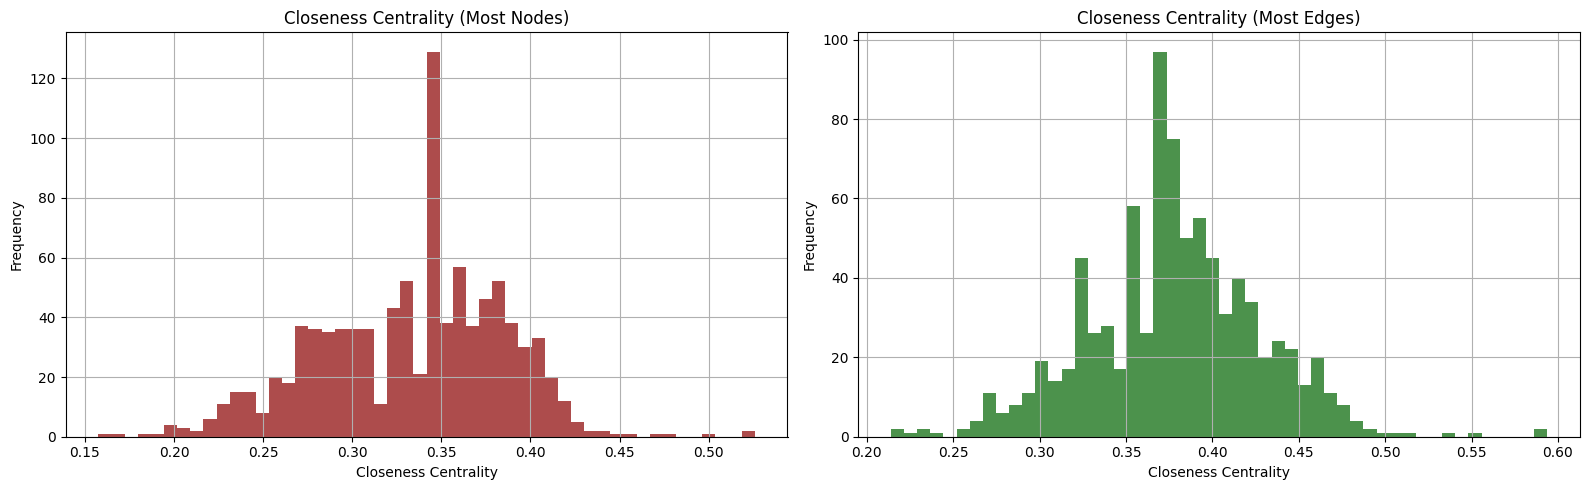

In [77]:
# Compute closeness centrality for both graphs
closeness_nodes = nx.closeness_centrality(graph_most_nodes)
closeness_edges = nx.closeness_centrality(graph_most_edges)

# Print top 5 nodes
print_top_5(closeness_nodes, "Closeness Centrality (Most Nodes)")
print_top_5(closeness_edges, "Closeness Centrality (Most Edges)")

# Plot distributions side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(closeness_nodes.values(), bins=50, color='darkred', alpha=0.7)
axs[0].set_title('Closeness Centrality (Most Nodes)')
axs[0].set_xlabel('Closeness Centrality')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].hist(closeness_edges.values(), bins=50, color='darkgreen', alpha=0.7)
axs[1].set_title('Closeness Centrality (Most Edges)')
axs[1].set_xlabel('Closeness Centrality')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Analysis

Despite the size difference, both graphs display a similar range and pattern, reinforcing previous findings that their core structures are comparable.

- Nodes in both graphs are well-connected globally, as reflected by their relatively high closeness centrality values.

- These results suggest that both graphs are structured in a way that information can flow efficiently, with most nodes being within a few steps of each other.
  

A central repository that can quickly reach or be reached from other nodes, based on the structure of the network and the fact that many nodes have closeness ≈ 0.35–0.40 suggests that most repos are fairly reachable—meaning in the GitHub network is well-connected overal

# 6.4 Eigenvector Centrality


### Eigenvector Centrality: Theory & Interpretation

Eigenvector centrality measures a node’s **importance** while giving consideration to the **importance of its neighbors**.  
A high eigenvector score means that a node is connected to many other nodes which themselves also have **high centrality scores**.

This allows the metric to capture **influence that extends beyond immediate neighbors**, unlike degree centrality which only considers direct connections.



#### Mathematical Definition

The eigenvector centrality $c_{v_i}$ of node $v_i$ is defined as the sum of the centralities of its neighbors:

$$
c_{v_i} = \frac{1}{\lambda} \sum_{v_j \in \mathcal{N}_i} A_{ij} c_{v_j}
$$

Where:
- $A_{ij}$ is the element of the adjacency matrix $\mathbf{A}$ (1 if there is an edge from $v_i$ to $v_j$),
- $\mathcal{N}_i$ is the set of neighbors of node $v_i$,
- $\lambda$ is a scaling factor (the largest eigenvalue of $\mathbf{A}$).

In matrix form, this becomes:

$$
\mathbf{A} \mathbf{c} = \lambda \mathbf{c}
$$

Where:
- $\mathbf{c}$ is the eigenvector of the adjacency matrix $\mathbf{A}$,
- $\lambda$ is its corresponding largest eigenvalue.


#### Interpretation

- **High eigenvector centrality** indicates that a node is not only well-connected, but also connected to **other well-connected nodes**.
- It identifies **hierarchically important** nodes that are central to the overall structure of the network.
- Suitable for networks where **indirect influence matters**, such as social networks, web graphs, or collaboration networks.



#### In GitHub Graph

In the context of GitHub:
- A developer or repository with **high eigenvector centrality** is likely linked to other **influential contributors** or projects.
- These nodes often lie at the **core of collaboration or influence**, serving as strategic bridges between key parts of the developer network.


Top 5 nodes for Eigenvector Centrality (Most Nodes):
Node: 448, Eigenvector Centrality (Most Nodes): 0.3611
Node: 824, Eigenvector Centrality (Most Nodes): 0.3084
Node: 586, Eigenvector Centrality (Most Nodes): 0.2994
Node: 499, Eigenvector Centrality (Most Nodes): 0.2269
Node: 529, Eigenvector Centrality (Most Nodes): 0.1564

Top 5 nodes for Eigenvector Centrality (Most Edges):
Node: 57, Eigenvector Centrality (Most Edges): 0.2891
Node: 347, Eigenvector Centrality (Most Edges): 0.2460
Node: 508, Eigenvector Centrality (Most Edges): 0.2124
Node: 68, Eigenvector Centrality (Most Edges): 0.2024
Node: 855, Eigenvector Centrality (Most Edges): 0.1715



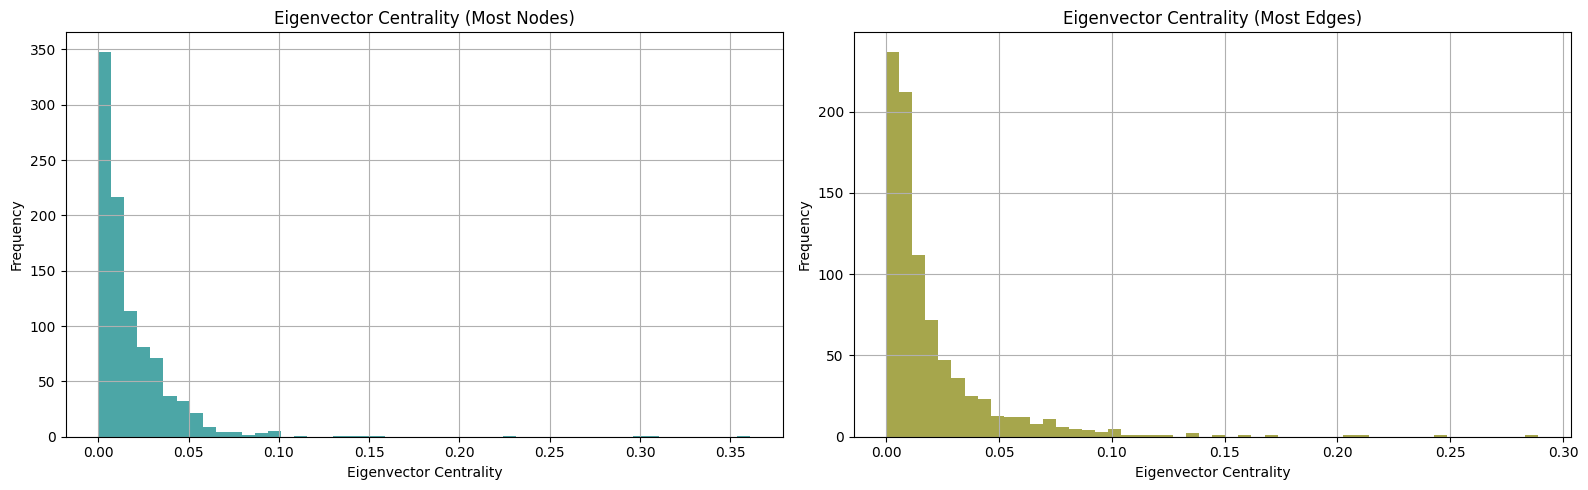

In [78]:
try:
    # Compute eigenvector centrality for both graphs
    eigen_nodes = nx.eigenvector_centrality(graph_most_nodes, max_iter=1000)
    eigen_edges = nx.eigenvector_centrality(graph_most_edges, max_iter=1000)

    # Print top 5 for both
    print_top_5(eigen_nodes, "Eigenvector Centrality (Most Nodes)")
    print_top_5(eigen_edges, "Eigenvector Centrality (Most Edges)")

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].hist(eigen_nodes.values(), bins=50, color='teal', alpha=0.7)
    axs[0].set_title('Eigenvector Centrality (Most Nodes)')
    axs[0].set_xlabel('Eigenvector Centrality')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)

    axs[1].hist(eigen_edges.values(), bins=50, color='olive', alpha=0.7)
    axs[1].set_title('Eigenvector Centrality (Most Edges)')
    axs[1].set_xlabel('Eigenvector Centrality')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

except nx.NetworkXException as e:
    print("Eigenvector centrality failed to converge on one or both graphs.")
    print("Error:", e)


# Analysis

The network has a highly centralized structure in terms of influence.

Node 16 plays again a critical role in connecting and influencing the rest of the network.

# 6.5  PageRank

### PageRank Centrality: Theory & Interpretation

PageRank centrality is a variant of **eigenvector centrality** originally developed by Google to rank web pages.  
It measures the importance of a node based not only on the **number of incoming links**, but also on the **quality (importance) of the source nodes**.  
In essence, a node receives a higher score if it is linked to by other **highly ranked nodes**.


#### Mathematical Representation

Given a directed graph $G = (V, E)$, let $d_i^+$ be the **out-degree** of node $v_i$.  
The **transition probability matrix** $P$ is defined as:

$$
P_{ij} =
\begin{cases} 
\frac{1}{d_i^+}, & \text{if } v_j \in \mathcal{N}_i^+ \\
0, & \text{otherwise}
\end{cases}
$$

where $\mathcal{N}_i^+$ is the set of neighbors that receive links from $v_i$.

Since $P$ is **row stochastic**, it satisfies:

$$
\sum_j P_{ij} = 1
$$


In matrix form, the PageRank vector $\mathbf{c}$ satisfies:

$$
\mathbf{c} = \lambda \mathbf{c} P \quad \text{with } \lambda = 1
$$

or equivalently:

$$
\mathbf{c} = (D^+)^{-1} A
$$

where:
- $A$ is the adjacency matrix of the graph,
- $D^+$ is the **diagonal matrix of out-degrees**.

To ensure convergence in graphs with dead ends or disconnected components, a **damping factor** $\alpha$ is introduced:

$$
\mathbf{c} = \alpha P \mathbf{c} + (1 - \alpha) \mathbf{v}
$$

where:
- $\alpha$ is typically set to 0.85,
- $\mathbf{v}$ is a teleportation vector (often uniform), ensuring a small probability of jumping to any node.


#### Interpretation

- Nodes with **high PageRank centrality** are important because they are referenced (linked to) by other **important nodes**.
- Unlike pure degree centrality, PageRank captures **recursive importance**.
- It is ideal for networks where **influence, reputation, or visibility** is propagated through connections.


#### In the GitHub Graph

In the context of GitHub:
- A developer or repository with **high PageRank** is likely referenced (e.g., followed, forked, contributed to) by **other influential developers or projects**.
- These nodes are likely to play a key role in **disseminating tools, ideas, or standards** across the developer community.


Top 5 nodes for PageRank (Most Nodes):
Node: 448, PageRank (Most Nodes): 0.0476
Node: 824, PageRank (Most Nodes): 0.0398
Node: 586, PageRank (Most Nodes): 0.0386
Node: 499, PageRank (Most Nodes): 0.0211
Node: 529, PageRank (Most Nodes): 0.0171

Top 5 nodes for PageRank (Most Edges):
Node: 347, PageRank (Most Edges): 0.0352
Node: 57, PageRank (Most Edges): 0.0337
Node: 508, PageRank (Most Edges): 0.0272
Node: 68, PageRank (Most Edges): 0.0192
Node: 855, PageRank (Most Edges): 0.0129



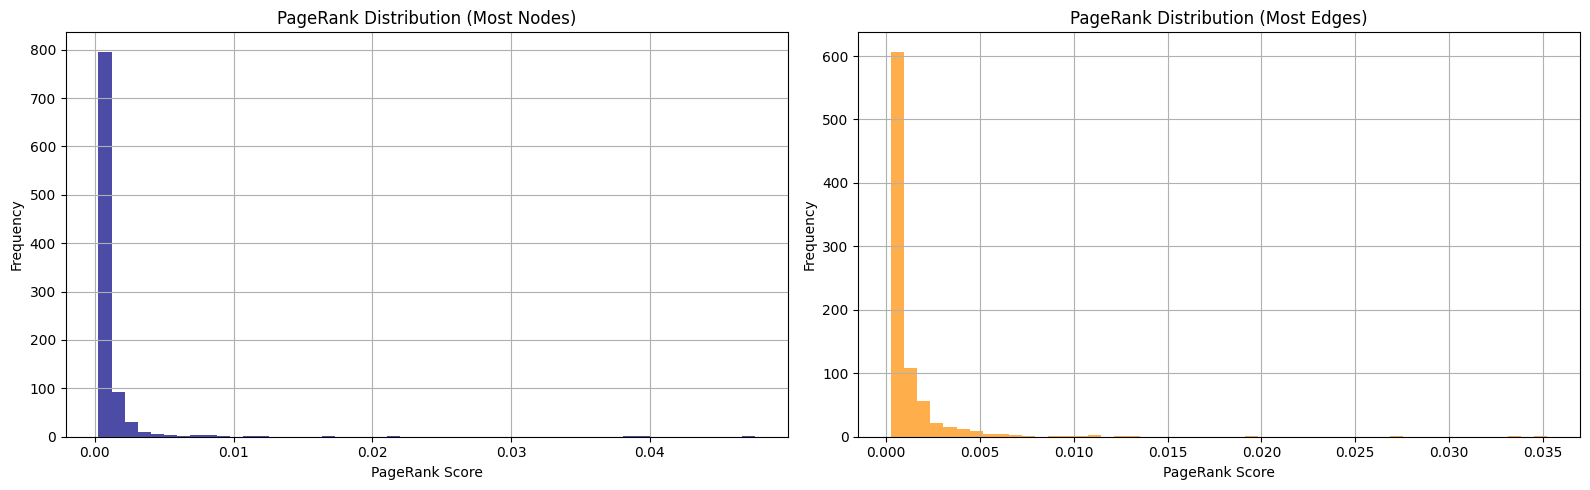

In [79]:
try:
    # Compute PageRank for both graphs
    pagerank_nodes = nx.pagerank(graph_most_nodes, alpha=0.85)
    pagerank_edges = nx.pagerank(graph_most_edges, alpha=0.85)

    # Print top 5 nodes
    print_top_5(pagerank_nodes, "PageRank (Most Nodes)")
    print_top_5(pagerank_edges, "PageRank (Most Edges)")

    # Plot distributions side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].hist(pagerank_nodes.values(), bins=50, color='navy', alpha=0.7)
    axs[0].set_title('PageRank Distribution (Most Nodes)')
    axs[0].set_xlabel('PageRank Score')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)

    axs[1].hist(pagerank_edges.values(), bins=50, color='darkorange', alpha=0.7)
    axs[1].set_title('PageRank Distribution (Most Edges)')
    axs[1].set_xlabel('PageRank Score')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("PageRank computation failed.")
    print("Error:", e)


# Analysis

Both graphs exhibit a highly skewed distribution, with the vast majority of nodes having very low PageRank scores.

- A small number of nodes have significantly higher scores, indicating that they are the core hubs—nodes that are:
Highly connected, Or connected to other important (high-ranking) nodes.



#  Katz Centrality

Katz centrality is an extension of **eigenvector centrality** that addresses its limitations in **disconnected** or **directed graphs**.

While eigenvector centrality works well only if the graph is **strongly connected**, Katz centrality ensures that **all nodes**, even those in isolated components, receive a non-zero centrality score.



#### Mathematical Definition

Katz centrality of a node $v_i$ is given by:

$$
c_{v_i} = \alpha \sum_j A_{ij} c_{v_j} + \beta
$$

Where:
- $A_{ij}$ is the element of the adjacency matrix $A$,
- $\alpha \in (0, 1)$ is the attenuation factor (controls the influence of distant nodes),
- $\beta$ is a positive constant (usually 1), providing each node a minimum baseline score.

In matrix form:

$$
\mathbf{c} = \alpha A \mathbf{c} + \mathbf{1}
$$

This recursive definition means a node is important if it is linked to by **other important nodes**, and **every node contributes something**.



#### Interpretation

- Katz centrality captures both **direct** and **indirect** influence.
- Nodes with high Katz scores are those that receive many short paths from other nodes—either directly or via influential intermediaries.
- Unlike eigenvector centrality, **peripheral or disconnected nodes** still receive a small score.


#### In the GitHub Graph

In the context of your GitHub-based graphs:
- A repository or developer with **high Katz centrality** is likely referenced (e.g., followed, forked, contributed to) by **many others**, including indirectly via shared connections.
- It helps highlight **globally relevant or foundational nodes** across the network, even in loosely connected structures.



Top 5 nodes for Katz Centrality (Most Nodes):
Node: 448, Katz Centrality (Most Nodes): 0.0834
Node: 824, Katz Centrality (Most Nodes): 0.0746
Node: 586, Katz Centrality (Most Nodes): 0.0731
Node: 499, Katz Centrality (Most Nodes): 0.0568
Node: 529, Katz Centrality (Most Nodes): 0.0512

Top 5 nodes for Katz Centrality (Most Edges):
Node: 57, Katz Centrality (Most Edges): 0.0901
Node: 347, Katz Centrality (Most Edges): 0.0862
Node: 508, Katz Centrality (Most Edges): 0.0753
Node: 68, Katz Centrality (Most Edges): 0.0669
Node: 855, Katz Centrality (Most Edges): 0.0576



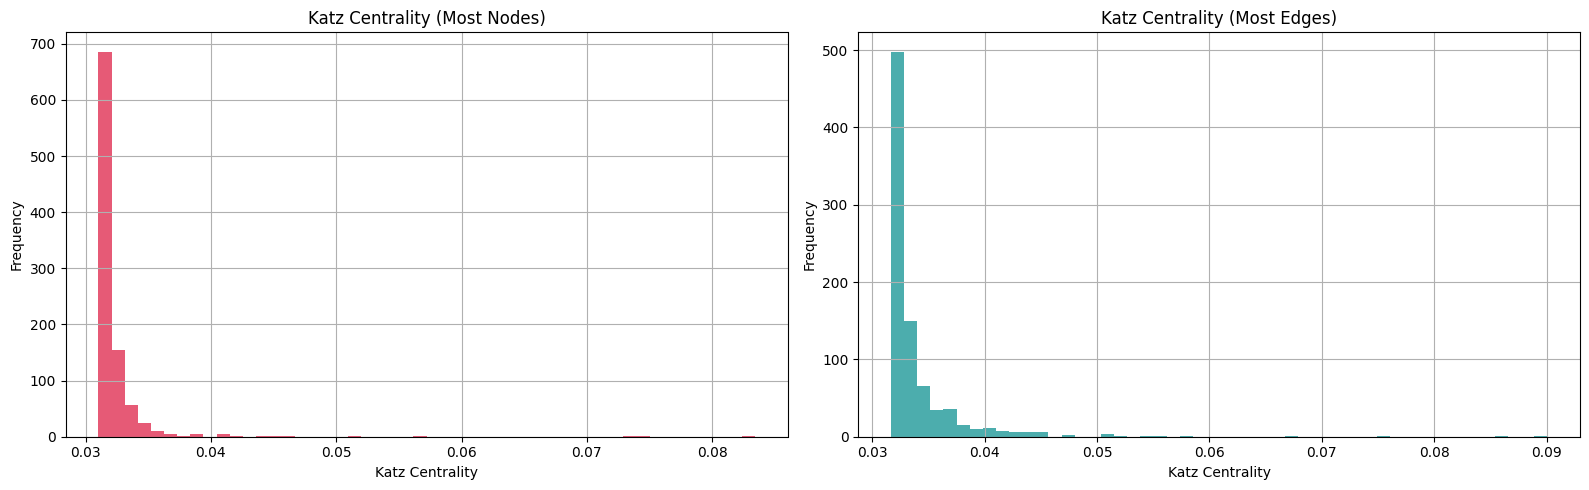

In [80]:
try:
    # Compute Katz centrality for both graphs
    katz_nodes = nx.katz_centrality(graph_most_nodes, alpha=0.005, beta=1.0, max_iter=1000, tol=1e-6)
    katz_edges = nx.katz_centrality(graph_most_edges, alpha=0.005, beta=1.0, max_iter=1000, tol=1e-6)

    # Print top 5
    print_top_5(katz_nodes, "Katz Centrality (Most Nodes)")
    print_top_5(katz_edges, "Katz Centrality (Most Edges)")

    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].hist(katz_nodes.values(), bins=50, color='crimson', alpha=0.7)
    axs[0].set_title('Katz Centrality (Most Nodes)')
    axs[0].set_xlabel('Katz Centrality')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)

    axs[1].hist(katz_edges.values(), bins=50, color='darkcyan', alpha=0.7)
    axs[1].set_title('Katz Centrality (Most Edges)')
    axs[1].set_xlabel('Katz Centrality')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Katz centrality computation failed.")
    print("Error:", e)


### Summary of all centrality analysis
- **Degree**: devs with many direct follower connections.
- **Betweenness**: devs bridging communities.
- **Closeness**: devs with short paths to others, indicating broad influence.
- **Eigenvector**: devs connected to other well-connected devs.
- **PageRank**: devs who accumulate importance based on inbound connections.
- **Katz**: devs with both direct and indirect influence, including those connected to influential peers and even those in sparsely connected regions.

Together, these can highlight key individuals in the dev network.

### 6.6 Borda Count

The **Borda Count** is a rank aggregation method originally developed for voting systems.  
In the context of **network centrality**, it allows us to **combine multiple centrality measures** into a single score that reflects overall importance.



#### How it works:

For each centrality measure (e.g., Degree, Betweenness, PageRank, etc.):
1. Nodes are **ranked** in descending order of importance.
2. The highest-ranked node receives the most points, the second-highest receives slightly fewer, and so on.
3. These points are **accumulated across all centrality measures**.

The final Borda score for a node is the **sum of its ranks across all measures**, with higher scores indicating stronger consensus across centralities.

In [81]:
degree_centrality = degree_nodes          
betweenness_centrality = betweenness_nodes
closeness_centrality = closeness_nodes     
eigenvector_centrality = eigen_nodes       
pagerank_centrality = pagerank_nodes       
katz_centrality = katz_nodes             

# Borda Count Function
def borda_count(centralities):
    borda_scores = {}
    for cent in centralities:
        sorted_nodes = sorted(cent.keys(), key=lambda x: cent[x], reverse=True)
        for rank, node in enumerate(sorted_nodes):
            if node not in borda_scores:
                borda_scores[node] = 0
            # Higher rank = higher score (rank 0 is best, so we invert it)
            borda_scores[node] += (len(sorted_nodes) - rank)
    return borda_scores

# Combine all centralities
all_centralities = [
    degree_centrality,
    betweenness_centrality,
    closeness_centrality,
    eigenvector_centrality,
    pagerank_centrality,
    katz_centrality
]

# Run Borda count
borda_scores = borda_count(all_centralities)
sorted_borda = sorted(borda_scores.items(), key=lambda x: x[1], reverse=True)

# Display results
print("Top 5 nodes based on Borda count:")
for node, score in sorted_borda[:5]:
    print(f"Node: {node}, Borda Score: {score}")


Top 5 nodes based on Borda count:
Node: 448, Borda Score: 5742
Node: 824, Borda Score: 5734
Node: 586, Borda Score: 5732
Node: 499, Borda Score: 5722
Node: 529, Borda Score: 5720


In [82]:
# Show centrality scores of the top Borda node across all centralities
top_node = sorted_borda[0][0]
print(f"Centrality breakdown for Node {top_node}:\n")

for name, cent in zip(
    ["Degree", "Betweenness", "Closeness", "Eigenvector", "PageRank", "Katz"],
    all_centralities
):
    print(f"{name:12}: {cent[top_node]:.5f}")


Centrality breakdown for Node 448:

Degree      : 0.33264
Betweenness : 0.28069
Closeness   : 0.52585
Eigenvector : 0.36111
PageRank    : 0.04756
Katz        : 0.08340


## 7 Community Detection

The **Girvan–Newman algorithm** is a popular method for detecting communities in complex networks.  
It is a **divisive hierarchical approach** that progressively removes edges with the **highest edge betweenness**, causing the graph to split into communities.

---

####  Edge Betweenness Centrality

The betweenness of an edge $e$ is defined as the number of shortest paths between all pairs of nodes $(s, t)$ that pass through $e$:

$$
\text{ebt}_e = \sum_{s \neq t} \frac{n_{s,t}^e}{n_{s,t}}
$$

Where:
- $n_{s,t}$ is the total number of shortest paths from node $s$ to node $t$,
- $n_{s,t}^e$ is the number of those paths that pass through edge $e$.

Edges with high $\text{ebt}_e$ are likely to **connect communities**, rather than lie within them.

---

#### Algorithm Steps

1. Compute edge betweenness for all edges.
2. **Remove the edge with the highest betweenness**.
3. Recompute betweenness and repeat until the graph splits into **disconnected components**.
4. Each resulting component is considered a **community**.

---

####  Application in This Analysis

- We apply Girvan–Newman to the full graph with the most nodes.
- We stop at the **first-level split** (2 communities).
- Each node is colored based on the community it belongs to.

This helps us reveal the **macroscopic structure** of the graph—whether it consists of tightly-knit subgroups connected by a few bridges.



Girvan-Newman split (first level): [39, 32]


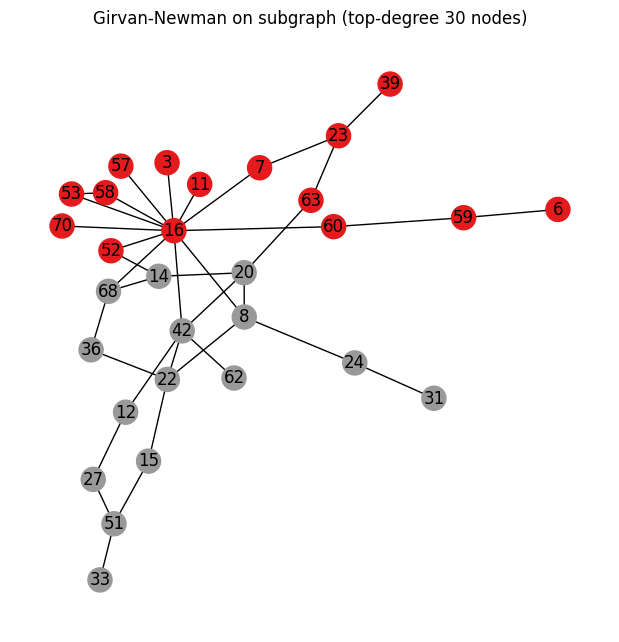

In [83]:
gn_gen = community.girvan_newman(sample_graph)
first_level_communities = next(gn_gen)
print("Girvan-Newman split (first level):", [len(c) for c in first_level_communities])

big_nodes = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:30]]
subg = sample_graph.subgraph(big_nodes)

subg_gn = community.girvan_newman(subg)
subg_first = next(subg_gn)
list_communities = list(subg_first)

community_map = {}
for i, cset in enumerate(list_communities):
    for node in cset:
        community_map[node] = i

pos = nx.spring_layout(subg, seed=42)
colors = [community_map[n] for n in subg.nodes()]
plt.figure(figsize=(6, 6))
nx.draw(subg, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set1)
plt.title("Girvan-Newman on subgraph (top-degree 30 nodes)")
plt.show()

# Analysis

The Girvan-Newman result confirms a clear modular structure in our graph with node 16 acting as a central bridge node between at least two communities. 

This adds strong support to earlier centrality findings and suggests that targeting or monitoring this node could significantly impact the connectivity or flow within the network.

######

### 7.1 Additional Community Utilities
We define helper functions to print stats and to visualize aggregated communities.

In [84]:
# Function to print community statistics
def print_community_stats(communities):
    print(f"Number of communities: {len(communities)}")
    sizes = [len(comm) for comm in communities]
    print(f"Community sizes: {sizes}")
    print(f"Largest community: {max(sizes)}")
    print(f"Smallest community: {min(sizes)}")
    print(f"Average community size: {np.mean(sizes):.2f}")
    print()

# Function to plot an aggregated community-graph
def plot_aggregated_communities(G, communities, title):
    community_graph = nx.Graph()
    for i, comm in enumerate(communities):
        community_graph.add_node(i, size=len(comm))
        for node in comm:
            for neighbor in G.neighbors(node):
                for j, other_comm in enumerate(communities):
                    if neighbor in other_comm and i != j:
                        if community_graph.has_edge(i, j):
                            community_graph[i][j]['weight'] += 1
                        else:
                            community_graph.add_edge(i, j, weight=1)

    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(community_graph, seed=42, k=10.0)

    edge_weights = [community_graph[i][j]['weight'] for i, j in community_graph.edges()]
    edge_colors = edge_weights

    norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    cmap = plt.get_cmap('viridis')

    nx.draw_networkx_nodes(community_graph, pos, node_size=300, node_color='lightblue', alpha=0.8, ax=ax)
    for node, (x, y) in pos.items():
        ax.text(x, y + 0.05, s=f"{community_graph.nodes[node]['size']}", 
                fontsize=10, ha='center', va='center', color='black')

    edges = nx.draw_networkx_edges(community_graph, pos, edge_color=edge_colors,
                                   width=2, alpha=0.6, edge_cmap=cmap, edge_vmin=min(edge_weights),
                                   edge_vmax=max(edge_weights), ax=ax)

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Edge Weight (Number of Connections)', shrink=0.8)

    nx.draw_networkx_labels(community_graph, pos, font_size=8, font_color='black', ax=ax)

    plt.title(title)
    plt.show()

### 7.2 Louvain Community Detection


The **Louvain method** is a fast, greedy algorithm for detecting non-overlapping communities by maximizing **modularity**.  
It is especially effective for large networks, such as social or collaboration graphs (like GitHub).

---

#### Modularity Score

Modularity measures the **quality of a partition** by comparing the actual number of edges within communities to the expected number if edges were placed at random.

The modularity $Q$ is defined as:

$$
Q = \frac{1}{2m} \sum_i \sum_j \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)
$$

Where:
- $A_{ij}$ is the adjacency matrix (1 if there's an edge, 0 otherwise),
- $k_i$, $k_j$ are the degrees of nodes $i$ and $j$,
- $m$ is the total number of edges in the graph,
- $c_i$ is the community assignment of node $i$,
- $\delta(c_i, c_j) = 1$ if $i$ and $j$ are in the same community, 0 otherwise.

---

#### How the Louvain Algorithm Works

The algorithm proceeds in **two main phases**, repeated until modularity no longer improves:

**Phase 1 – Local Optimization:**
- Each node starts in its own community.
- Nodes are moved to neighboring communities **if the move improves modularity**.

**Phase 2 – Community Aggregation:**
- Communities from Phase 1 are **collapsed into super-nodes**.
- The process is repeated on the newly constructed graph.

---

####  Why Use Louvain?

- **Efficient**: Works in $O(n \log n)$ time.
- **Scalable**: Handles large-scale graphs easily.
- **Hierarchical**: Naturally creates community hierarchies (can stop at any level).

---

#### In This Analysis

We applied the Louvain algorithm to onte graph to uncover its **modular structure**.  
The detected communities represent **clusters of developers or repositories** that are more tightly connected internally than to the rest of the network.



Louvain Communities:
Number of communities: 10
Community sizes: [25, 2, 5, 5, 14, 2, 9, 3, 4, 2]
Largest community: 25
Smallest community: 2
Average community size: 7.10



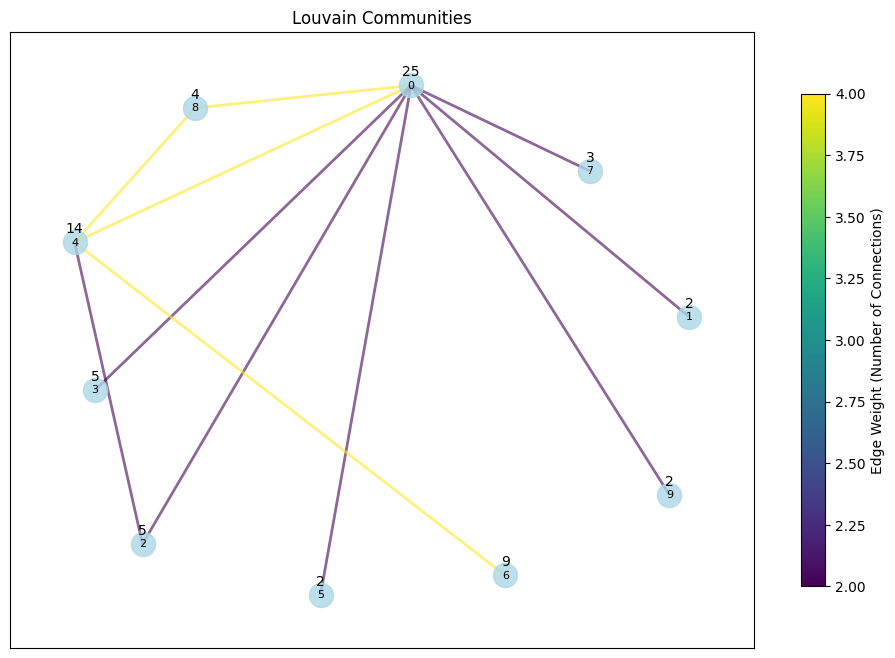

In [85]:
try:
    def louvain_communities(G):
        partition = community_louvain.best_partition(G)
        comms = defaultdict(list)
        for node, comm_id in partition.items():
            comms[comm_id].append(node)
        return list(comms.values())

    print("Louvain Communities:")
    louvain_coms = louvain_communities(sample_graph)
    print_community_stats(louvain_coms)
    plot_aggregated_communities(sample_graph, louvain_coms, "Louvain Communities")
except:
    print("Install python-louvain to run Louvain.")

# Analysis

In this analysis, we applied the Louvain algorithm to a **single GitHub interaction graph** to uncover its **modular structure**.

####  Well-Defined Communities
- The method identified **11 distinct communities**, indicating good modularity for a non-uniform graph.

#### Dominant Core
- One community is significantly larger (**25 nodes**), representing a **core cluster** of highly connected nodes.
  
#### Diversity in Structure
- Several **smaller communities (2–4 nodes)** were detected, reflecting **localized clusters** or possibly **peripheral or bridge roles**.

#### Edge Weight Context (if visualized)
- **Higher-weight edges (e.g., yellow edges)** may suggest **stronger or more frequent interactions**, which is relevant when studying influence or communication flow within the network.


######

## 9 Silhouette 

Is a method for evaluating the **quality of clustering**, in this case, the communities detected within a graph.

It measures how well-separated and cohesive the communities are, based on **pairwise distances between nodes**.

---

####  Silhouette Score Definition

For each node $i$, the silhouette score $s(i)$ is computed as:

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

Where:
- $a(i)$ = average distance from node $i$ to all other nodes in the **same cluster** (intra-cluster distance),
- $b(i)$ = minimum average distance from node $i$ to nodes in any **other cluster** (nearest-cluster distance).

The overall **silhouette score** is the mean of $s(i)$ over all nodes.

- $s(i) \approx 1$ → node is well clustered.
- $s(i) \approx 0$ → node lies between two clusters.
- $s(i) < 0$ → node may be in the wrong cluster.

---

####  How It Works in This Analysis

1. We extract the **largest connected component** of the graph to ensure meaningful distance computation.
2. Compute the **shortest path distance matrix** between nodes.
3. Convert the community list into a label vector using `community_to_labels()`.
4. Use `silhouette_score()` with a **precomputed distance matrix** to evaluate how well nodes are assigned to communities.

---

####  Why Use Silhouette?

- It offers a **quantitative measure** of community quality, regardless of the algorithm used (e.g., Louvain, Girvan–Newman).
- It helps validate whether the structure found is **coherent and separable**.
- Particularly useful in comparing **different community detection methods** or **different parameter choices**.

---

> **Note:** A valid silhouette score requires at least **2 communities**; otherwise, it cannot be computed.


In [86]:
def compute_distance_matrix(G):
    shortest_paths = dict(nx.shortest_path_length(G))
    distance_matrix = np.zeros((len(G), len(G)))
    nodes = list(G.nodes())
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if v in shortest_paths[u]:
                distance_matrix[i, j] = shortest_paths[u][v]
            else:
                distance_matrix[i, j] = nx.diameter(G) + 1
    return distance_matrix, nodes

In [87]:
# Helper to convert community format into cluster labels aligned with a given node_list
def community_to_labels(communities, node_list):
    label_map = {}
    # Assign a cluster label to each node
    for i, comm in enumerate(communities):
        for node in comm:
            label_map[node] = i

    # Create a label array for each node in node_list
    labels = []
    for n in node_list:
        # If a node isn't in any community, assign -1
        labels.append(label_map.get(n, -1))
    return labels

# Function to compute silhouette score given a Graph and a list of communities
def compute_silhouette_score(G, communities, threshold=3):
    # Work on the largest connected component
    Gcc = G.subgraph(max(nx.connected_components(G), key=len))
    dist_matrix, node_list = compute_distance_matrix(Gcc)

    # Filter communities to keep only nodes within Gcc
    comm_in_cc = []
    for c in communities:
        subc = [n for n in c if n in Gcc]
        if len(subc) > 0:
            comm_in_cc.append(subc)

    # Build cluster labels
    cluster_labels = community_to_labels(comm_in_cc, sorted(Gcc.nodes()))

    # Need at least 2 clusters for silhouette
    if len(set(cluster_labels)) < 2:
        print("Cannot compute silhouette with fewer than 2 clusters.")
        return None

    # Silhouette with 'precomputed' distance
    sil_score = silhouette_score(dist_matrix, cluster_labels, metric='precomputed')
    return sil_score

In [88]:
try:
    if 'louvain_coms' in globals():
        sil_louvain = compute_silhouette_score(sample_graph, louvain_coms)
        if sil_louvain is not None:
            print(f"Silhouette score (Louvain): {sil_louvain:.4f}")
except:
    print("Louvain silhouette failed.")

# Girvan-Newman full graph, first level
GN_full_coms = list(first_level_communities)
if len(GN_full_coms) > 1:
    sil_gn = compute_silhouette_score(sample_graph, GN_full_coms)
    if sil_gn is not None:
        print(f"Silhouette score (Girvan-Newman, first level): {sil_gn:.4f}")

Silhouette score (Louvain): -0.2282
Silhouette score (Girvan-Newman, first level): -0.0013


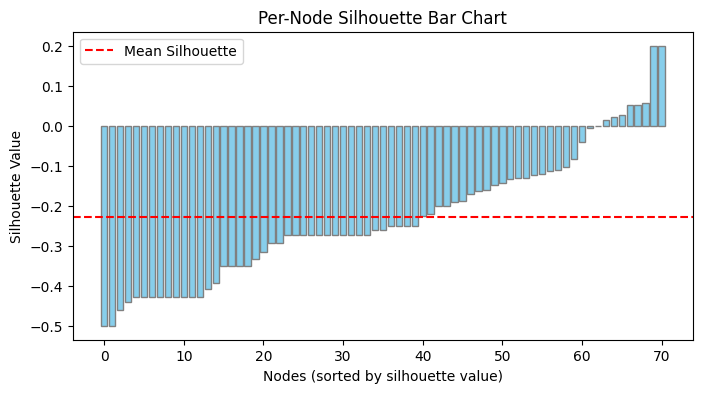

In [89]:
def plot_silhouette_bars(G, communities, threshold=3):
    """
    Compute silhouette *per node* in the largest connected component,
    then visualize it as a bar chart.
    """
    # Work on the largest connected component
    Gcc = G.subgraph(max(nx.connected_components(G), key=len))
    dist_matrix, node_list = compute_distance_matrix(Gcc)

    # Filter communities so they only include nodes in this component
    comm_in_cc = []
    for c in communities:
        subc = [n for n in c if n in Gcc]
        if len(subc) > 0:
            comm_in_cc.append(subc)

    # Convert these communities to labels
    cluster_labels = community_to_labels(comm_in_cc, sorted(Gcc.nodes()))

    # Check if we have at least 2 clusters
    unique_clusters = set(cluster_labels)
    if len(unique_clusters) < 2:
        print("Cannot compute silhouette bars with fewer than 2 clusters.")
        return

    # Compute individual silhouette values
    sil_values = silhouette_samples(dist_matrix, cluster_labels, metric='precomputed')

    # Sort them just for a nicer plot; you could group them by cluster if you prefer
    sorted_sil = sorted(sil_values)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(sorted_sil)), sorted_sil, color='skyblue', edgecolor='gray')
    plt.axhline(np.mean(sil_values), color='red', linestyle='--', label='Mean Silhouette')
    plt.xlabel("Nodes (sorted by silhouette value)")
    plt.ylabel("Silhouette Value")
    plt.title("Per-Node Silhouette Bar Chart")
    plt.legend()
    plt.show()

plot_silhouette_bars(sample_graph, louvain_coms)


# Analysis

Despite the intuitive visual community structures from Louvain and Hierarchical clustering, the silhouette analysis reveals that these partitions may not be strongly supported by the graph’s internal node distances.

#####

## Leiden Community Detection

The **Leiden algorithm** is a robust method for detecting communities in graphs. It improves on the **Louvain algorithm** by producing communities that are:

- **Internally well-connected** (no disconnected sub-parts),
- **More stable and accurate**, 
- **Faster to converge** in large-scale graphs.

---

###  Theoretical Foundation

The algorithm optimizes the **modularity** score \( Q \), which measures the strength of division of a network into modules (communities):

$$
Q = \frac{1}{2m} \sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)
$$

Where:
- $ A_{ij} $: adjacency matrix (1 if edge exists between nodes $i$ and $j$, 0 otherwise),
- $k_i$: degree of node $i$,
- $m$: total number of edges,
- $\delta(c_i, c_j)$: Kronecker delta (1 if $i$ and $j$ are in the same community),
- $Q \in [-1, 1] \$: higher $Q$ → better-defined communities.

---

### Application in This Project

- Selected a subgraph of the **top 30 nodes** by degree.
- Used `igraph` + `leidenalg.ModularityVertexPartition`.
- Visualized communities using color-coded layouts.

---

### Evaluation with Silhouette Score

To assess cluster quality, we used the **Silhouette Score**:

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

Where:
- $a(i)$: average distance from node $i$ to all nodes in the **same community**,
- $b(i)$: lowest average distance from node $i$ to nodes in a **different community**.

Silhouette interpretation:
- $s(i) \approx 1$: well-clustered,
- $ s(i) \approx 0 $: on the boundary,
- $ s(i) < 0$: possibly misclassified.



## 9.1 Community Detection with Leiden and Silhouette Evaluation


Leiden community sizes: [7, 7, 5, 4, 4, 3]


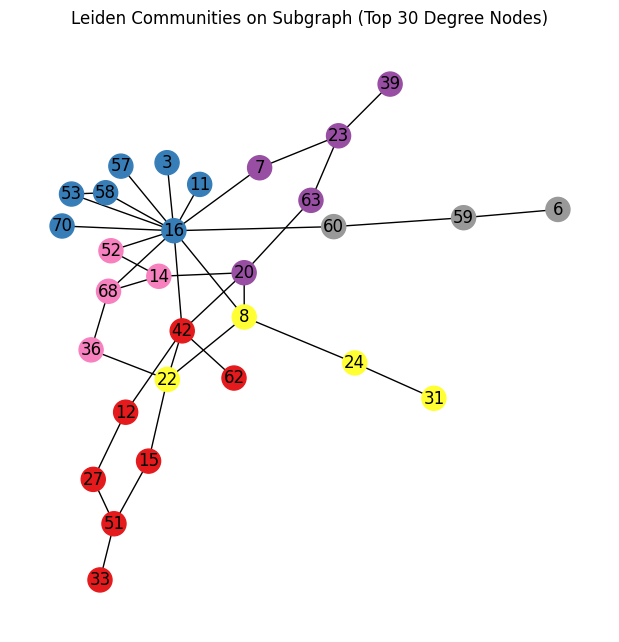

In [90]:
big_nodes = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:30]]
subg = sample_graph.subgraph(big_nodes).copy()
edges = list(subg.edges())
g_igraph = ig.Graph.TupleList(edges, directed=False)
partition = leidenalg.find_partition(g_igraph, leidenalg.ModularityVertexPartition)

# Convert iGraph community output to list of nodes
leiden_coms = []
for community in partition:
    leiden_coms.append([int(g_igraph.vs[idx]["name"]) for idx in community])  

print("Leiden community sizes:", [len(c) for c in leiden_coms])

# Plot communities in the subgraph 
community_map = {}
for i, cset in enumerate(leiden_coms):
    for node in cset:
        community_map[node] = i

pos = nx.spring_layout(subg, seed=42)
colors = [community_map[n] for n in subg.nodes()]
plt.figure(figsize=(6, 6))
nx.draw(subg, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set1)
plt.title("Leiden Communities on Subgraph (Top 30 Degree Nodes)")
plt.show()


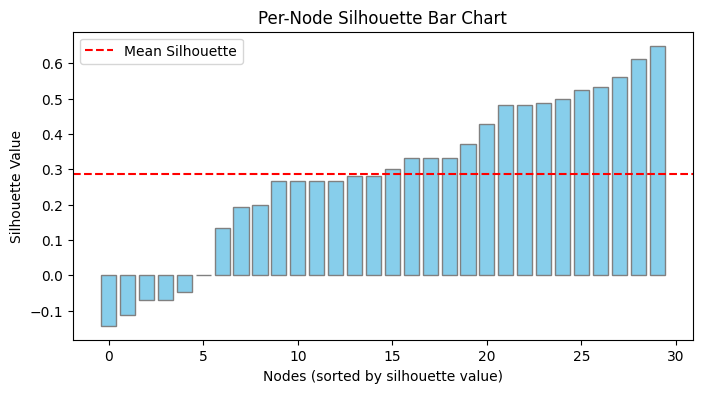

In [91]:
plot_silhouette_bars(subg, leiden_coms)


# Analysis

Visually, the communities are compact and well-separated and the node coloring shows clear modular structure with very little overlap.

Most nodes have silhouette > 0, indicating they're well-assigned. Only 4 nodes have slightly negative values indicating minimal misclassification. Mean silhouette is positive, showing strong internal cohesion and good separation between communities.

We can conclude the Leiden Comunities performed significantly better than Louvain, Hierarchical, and Girvan-Newman.

### Graph Embeddings: Node2Vec & Spectral Methods

Graph embeddings transform nodes from a graph into continuous vector representations in a low-dimensional space.  
These embeddings preserve important structural properties, enabling visualization, clustering, and learning tasks (e.g., classification, link prediction).

We apply and compare two core embedding techniques:
- **Node2Vec** – based on biased random walks
- **Spectral Embedding** – based on the graph Laplacian (Laplacian Eigenmaps)

---

###  Node2Vec

Node2Vec is a **random walk–based encoder-decoder method** that learns node embeddings by simulating second-order biased walks and applying the Word2Vec SkipGram model.

####  Core Idea:
Nodes that **co-occur in random walks** should have **similar embeddings**. The embedding function $f(u)$ is learned such that:

$$
\max_f \sum_u \sum_{v \in \mathcal{N}_S(u)} \log P(v|f(u))
$$

Where:
- $\mathcal{N}_S(u)$ is the set of nodes visited in the random walks starting at node $u$
- $P(v|f(u))$ is computed using softmax over the dot product:

$$
P(v|f(u)) = \frac{e^{f(u)^T f(v)}}{\sum_{w \in V} e^{f(u)^T f(w)}}
$$

#### Decoder:
The probability that node $u$ is close to $v$ is approximated as:

$$
DEC(Z[u], Z[v]) = \frac{e^{Z[u]^T Z[v]}}{\sum_w e^{Z[u]^T Z[w]}}
$$

#### Walk Strategy:
Node2Vec introduces **second-order bias** with parameters $p$ and $q$ to guide walks:
- Return parameter $p$: controls likelihood of returning to previous node
- In-out parameter $q$: balances BFS (local view) and DFS (structural role)

The bias $\alpha$ for transition $(v^*, v_i)$ is:

$$
\alpha(v^*, v_i) = 
\begin{cases}
\frac{1}{p} & \text{if } d(v^*, v_i) = 0 \\
1 & \text{if } d(v^*, v_i) = 1 \\
\frac{1}{q} & \text{if } d(v^*, v_i) = 2
\end{cases}
$$

####  Interpretation:
- Preserves both **local** and **global** graph structure
- Nodes that appear in similar structural contexts tend to be **closer in embedding space**
- Requires full graph (transductive)

---

### 2. Spectral Embedding (Laplacian Eigenmaps)

Spectral embedding is a **Laplacian-based method** that uses the graph’s eigenvectors to represent the global structure of the network.

####  Laplacian Matrix:
Given a graph $G = (V, E)$ with adjacency matrix $A$ and degree matrix $D$, the unnormalized Laplacian is:

$$
L = D - A
$$

The **normalized Laplacian** (used in practice) is:

$$
L_{sym} = D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$

####  Laplacian Eigenmaps:
The embedding is obtained by solving the following:

$$
\min_{Z \in \mathbb{R}^{|V| \times d}} \sum_{(i,j) \in E} ||Z_i - Z_j||^2
$$

Subject to:  
- $Z^T Z = I$  
- $Z \mathbf{1} = 0$

This reduces to computing the **$d$ smallest non-zero eigenvectors** of $L_{sym}$.

#### Intuition:
Minimizing $Z^T L Z$ ensures that **connected nodes have similar embeddings**.  
These embeddings reflect **smooth structural variations** in the graph, ideal for **clustering and visualization**.

---

By visualizing both embeddings in 2D using PCA, we gain insight into how different methods interpret **node similarity** and **community structure** from different perspectives.


Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 329.38it/s]


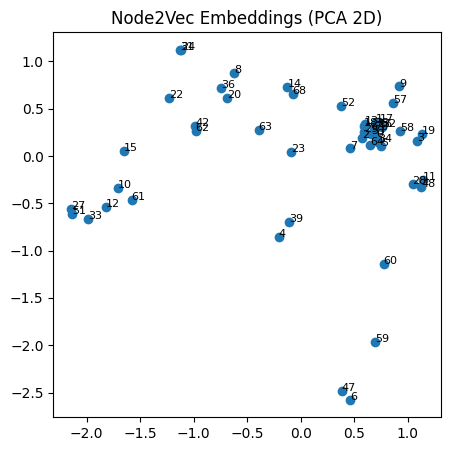

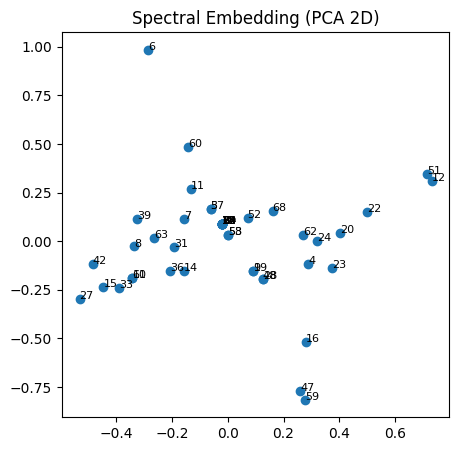

In [92]:
big_nodes_50 = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:50]]
g_sub = sample_graph.subgraph(big_nodes_50).copy()

# Node2Vec Embedding
try:
    from node2vec import Node2Vec
    node2vec_model = Node2Vec(g_sub, dimensions=16, walk_length=10, num_walks=50, workers=1)
    n2v = node2vec_model.fit(window=5, min_count=1)

    emb_array = []
    node_list = list(g_sub.nodes())
    for node in node_list:
        if str(node) in n2v.wv:
            emb_array.append(n2v.wv[str(node)])
        else:
            emb_array.append(np.zeros(16))
    emb_array = np.array(emb_array)

    pca_2d = PCA(n_components=2)
    node2vec_2d = pca_2d.fit_transform(emb_array)

    plt.figure(figsize=(5, 5))
    plt.scatter(node2vec_2d[:, 0], node2vec_2d[:, 1])
    for i, nd in enumerate(node_list):
        plt.text(node2vec_2d[i, 0], node2vec_2d[i, 1], str(nd), fontsize=8)
    plt.title("Node2Vec Embeddings (PCA 2D)")
    plt.show()

except ImportError:
    print("Please install node2vec via pip install node2vec")

# Spectral Embedding
lap = nx.normalized_laplacian_matrix(g_sub)
lapdense = lap.todense()

pca_spec = PCA(n_components=2)
spectral_2d = pca_spec.fit_transform(lapdense)

plt.figure(figsize=(5, 5))
plt.scatter(spectral_2d[:, 0], spectral_2d[:, 1])
for i, nd in enumerate(g_sub.nodes()):
    plt.text(spectral_2d[i, 0], spectral_2d[i, 1], str(nd), fontsize=8)
plt.title("Spectral Embedding (PCA 2D)")
plt.show()

# Analysis

Node2Vec shows strong potential for detecting core clusters or central nodes.

We have a clear cluster on the right, where many nodes (dense labels) are tightly packed likely a community or tightly connected core.



#### : t-SNE (Dimensionality Reduction to 2D)

- **t-SNE (t-distributed Stochastic Neighbor Embedding)** is a non-linear dimensionality reduction method used to project high-dimensional embeddings into **2D** for visualization.

- It aims to **preserve local similarities**, making clusters easier to interpret visually.

> Perplexity: controls the balance between local/global structure (we used 15).  
> Initialization: PCA for better convergence.

---

#### : KMeans Clustering

- **KMeans** is applied to the original 16D embeddings (standardized) to detect **structural groupings** of nodes.
- We specify `k = 3` clusters as a starting point to capture coarse community structures.

This allows us to:
- **Quantify latent roles or positions** of nodes in embedding space.
- Compare how different embedding methods (Node2Vec vs. Spectral) group nodes differently.
- Evaluate the overlap with known community structure or labels.

---

###  Visualization

The resulting 2D plots show:
- Node positions after t-SNE projection.
- Coloring based on **KMeans cluster assignment**.
- Labels on nodes to inspect identity and spatial cohesion.

This joint method gives both **qualitative (visual)** and **quantitative (cluster)** insight into the graph’s embedding geometry.

---


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 473.45it/s]


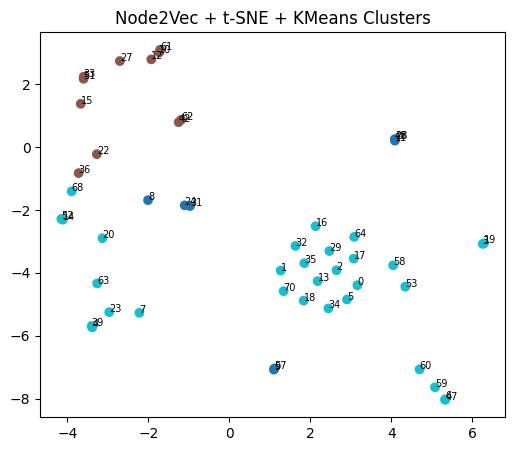

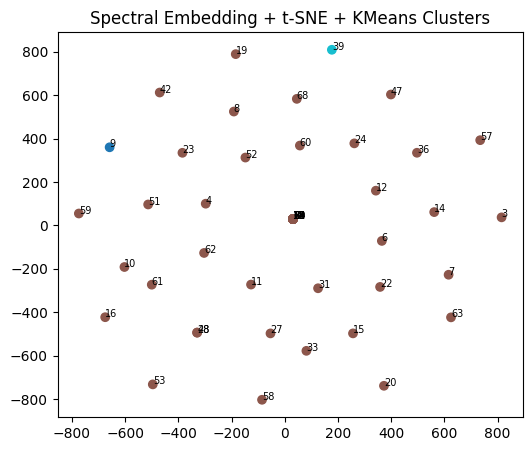

In [93]:
#Node2Vec Embedding + t-SNE + KMeans
# Node2Vec model
node2vec_model = Node2Vec(g_sub, dimensions=16, walk_length=10, num_walks=50, workers=1, seed=42)
n2v = node2vec_model.fit(window=5, min_count=1)

node_list = list(g_sub.nodes())
emb_array = [n2v.wv[str(node)] if str(node) in n2v.wv else np.zeros(16) for node in node_list]
emb_array = np.array(emb_array)

# Standardize before clustering and t-SNE
scaler = StandardScaler()
emb_array_scaled = scaler.fit_transform(emb_array)

# t-SNE
tsne_n2v = TSNE(n_components=2, random_state=42, perplexity=15, init='pca')
n2v_tsne = tsne_n2v.fit_transform(emb_array_scaled)

# KMeans clustering
kmeans_n2v = KMeans(n_clusters=3, random_state=42)
labels_n2v = kmeans_n2v.fit_predict(emb_array_scaled)

# Plot Node2Vec t-SNE with KMeans clusters
plt.figure(figsize=(6, 5))
plt.scatter(n2v_tsne[:, 0], n2v_tsne[:, 1], c=labels_n2v, cmap='tab10')
for i, node in enumerate(node_list):
    plt.text(n2v_tsne[i, 0], n2v_tsne[i, 1], str(node), fontsize=7)
plt.title("Node2Vec + t-SNE + KMeans Clusters")
plt.show()


# Spectral Embedding + t-SNE + KMeans
# Spectral embedding (using normalized Laplacian)
lap = nx.normalized_laplacian_matrix(g_sub).todense()

# Reduce with PCA first if needed (optional here since lap is already dense)
pca_spectral = PCA(n_components=16)
spec_emb = pca_spectral.fit_transform(lap)

# Standardize
spec_emb_scaled = scaler.fit_transform(spec_emb)

# t-SNE
tsne_spec = TSNE(n_components=2, random_state=42, perplexity=15, init='pca')
spec_tsne = tsne_spec.fit_transform(spec_emb_scaled)

# KMeans clustering
kmeans_spec = KMeans(n_clusters=3, random_state=42)
labels_spec = kmeans_spec.fit_predict(spec_emb_scaled)

# Plot Spectral t-SNE with KMeans clusters
plt.figure(figsize=(6, 5))
plt.scatter(spec_tsne[:, 0], spec_tsne[:, 1], c=labels_spec, cmap='tab10')
for i, node in enumerate(node_list):
    plt.text(spec_tsne[i, 0], spec_tsne[i, 1], str(node), fontsize=7)
plt.title("Spectral Embedding + t-SNE + KMeans Clusters")
plt.show()


# Analysis

Node2Vec + t-SNE + KMeans -> Clustering is well-formed: We can clearly see 3 separate groups, with minimal overlap. This confirms that Node2Vec captures latent network features effectively.

Spectral Embedding + t-SNE + KMeans -> Clusters are not clearly separated points are spread almost uniformly across the plot. This suggests Spectral Embedding is not capturing strong modular structure, or the graph lacks clear partitions under this method.



### Graphs Convolutional Networks

The main goal is to predict whether a link (edge) should exist between two nodes in a graph. We rely on a GNN that learns to embed each node into a latent space where edges can be inferred from the node embeddings.

### Data Preparation

1. Graph Construction: we've chosen to analyze the graphs with most nodes and most edges.
- The nodes don't have any feature (just the whole graph), so we use an identity vector for each node.
2. Splitting Edges into Train, Validation, and Test We divide the existing edges into three categories:
- Training edges: The graph is partially “masked,” exposing only these edges to the model.
- Validation edges: Used intermittently during training (e.g., every few epochs) to check if the model is overfitting.
- Test edges: Strictly for final evaluation, ensuring the model generalizes beyond the training data. Additionally, we create negative samples (pairs of nodes that do not share an edge) for each of these sets. This allows the model to learn a binary distinction between connected vs. disconnected node pairs.

In [94]:
max_nodes = 0
max_edges = 0
graph_with_most_nodes = -1
graph_with_most_edges = -1

for i, edges in enumerate(edge_lists):
    # extrai todos os nós únicos daquele grafo
    node_ids = set([n for edge in edges for n in edge])
    num_nodes = len(node_ids)
    num_edges = len(edges)

    if num_nodes > max_nodes:
        max_nodes = num_nodes
        graph_with_most_nodes = i

    if num_edges > max_edges:
        max_edges = num_edges
        graph_with_most_edges = i

print(f"Graph with most NODES: ID {graph_with_most_nodes}, {max_nodes} nodes")
print(f"Graphs with most EDGES: ID {graph_with_most_edges}, {max_edges} edges")

graph_most_nodes = graphs[graph_with_most_nodes]
graph_most_edges = graphs[graph_with_most_edges]

Graph with most NODES: ID 1408, 957 nodes
Graphs with most EDGES: ID 5058, 4668 edges


In [95]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

def nx_to_pyg_data(graph_nx, label=None, use_node_attributes=False):
    """
    Converts a networkx graph to a PyG Data object.

    Parameters:
    -----------
    graph_nx : networkx.DiGraph or Graph
        Input graph.
    
    label : int or tensor (optional)
        Global label of the graph (e.g. 0 = WebDev, 1 = ML).
    
    use_node_attributes : bool
        If True, uses attributes of the node present in the networkx.
        If False, generates one-hot (identity) as a feature.

    Returns:
    --------
    data : torch_geometric.data.Data
        Object ready for GNN (with x, edge_index, num_nodes, y).
    """
    data = from_networkx(graph_nx)

    num_nodes = graph_nx.number_of_nodes()

    if use_node_attributes:
        if hasattr(data, 'feature'):
            data.x = data.feature.float()
        else:
            raise ValueError("Graph does not contain node attributes named 'feature'")
    else:
        data.x = torch.eye(num_nodes)

    data.num_nodes = num_nodes

    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)

    return data

d:\GraphMining\GraphMining\Graph\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] La procédure spécifiée est introuvable
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
d:\GraphMining\GraphMining\Graph\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] La procédure spécifiée est introuvable
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## GAE Architecture

A **Graph Auto-Encoder (GAE)** is designed specifically for **link prediction**, using an encoder-decoder framework:

1. **Encoder**: A GNN (e.g., a 2-layer GCN) maps each node to a latent embedding, often denoted $\mathbf{z}_u$.
2. **Decoder**: Computes a similarity measure (often a dot product) between two node embeddings to determine whether an edge should exist.

### Encoder (GNN)

The encoder typically follows standard GCN principles:

1. **Graph Convolution (Message Passing):** each node aggregates feature information from its neighbors.  
2. **Nonlinear Activation (e.g., ReLU):** provides expressiveness in capturing structural and feature-based context.  
3. **Final Node Embedding:** after one or more convolution layers, each node $u$ has an embedding vector $\mathbf{z}_u$. This vector encodes both the node’s own attributes and the local neighborhood structure.

Formally, for a two-layer GCN encoder:

$$
\mathbf{Z} = \text{GCNConv}_2\!\Bigl(\text{ReLU}\bigl(\text{GCNConv}_1(\mathbf{X}, \mathbf{A})\bigr) , \mathbf{A}\Bigr),
$$

where:
- $\mathbf{X}$ is the feature matrix (nodes $\times$ features),
- $\mathbf{A}$ is the adjacency matrix (or edge index in a sparse representation),
- $\mathbf{Z}$ is the final matrix of embeddings.

### Decoder (Link Reconstruction)

The GAE decoder tries to **reconstruct** the edges of the graph by calculating a score for each pair of nodes $(u, v)$. A common choice is the **dot product**:

$$
\widehat{A}_{uv} = \sigma\bigl(\mathbf{z}_u \cdot \mathbf{z}_v\bigr),
$$

where $\sigma$ is the sigmoid function, producing a probability-like score indicating whether an edge should exist.

### Training Objective: Graph Reconstruction

To train the model, we treat the link prediction as a **binary classification** problem:

- **Positive pairs**: existing edges in the training subgraph.
- **Negative pairs**: sampled node pairs that do not have an edge.

A **binary cross-entropy loss** pushes the model to produce higher dot products for positive pairs and lower values for negative pairs:

$$
\mathcal{L} = \sum_{(u,v)\in D^+} -\log \sigma\bigl(\mathbf{z}_u \cdot \mathbf{z}_v\bigr) 
\;+\; \sum_{(u',v')\in D^-} -\log \Bigl(1 - \sigma\bigl(\mathbf{z}_{u'} \cdot \mathbf{z}_{v'}\bigr)\Bigr),
$$

where $D^+$ is the set of true edges and $D^-$ is the set of negative (non-edge) samples.

### Putting It All Together

1. **Forward Pass**:  
   - The GNN encoder produces embeddings $\mathbf{z}$ for each node.  
   - The decoder takes pairs of embeddings and computes dot products to estimate whether an edge exists.  

2. **Loss Computation**:  
   - Compare the predicted probabilities $\widehat{A}_{uv}$ with the ground truth (edge or no edge).  
   - Use BCE loss to encourage accurate reconstruction.  

3. **Backpropagation**:  
   - Gradients flow back through the decoder and then the encoder, updating GCN weights.  

4. **Inference**:  
   - Once trained, the GAE can predict missing edges or potential future links in the graph by evaluating $\mathbf{z}_u \cdot \mathbf{z}_v$ for any pair of nodes $u, v$.

## 1. GCN em Detalhes

A ideia principal de um GCN (Graph Convolutional Network) é **generalizar o conceito de convolução para grafos**. Em vez de ter pixels vizinhos (como em imagens), cada nó tem **vizinhos** conectados por arestas. 

### 1.1. Representação de Entradas

- $\mathbf{X} \in \mathbb{R}^{N \times F}$: Matriz de features, onde $N$ é o número de nós e $F$ é a dimensão dos atributos.
- $\mathbf{A} \in \mathbb{R}^{N \times N}$: Matriz de adjacência (pode ser binária, ponderada etc.). Em bibliotecas como PyTorch Geometric, usamos `edge_index` no formato esparso, mas conceitualmente é a mesma ideia.

> Em muitos trabalhos, adicionamos **self-loops** ($\mathbf{A} + \mathbf{I}$) para permitir que um nó use também sua própria informação.

### 1.2. Normalização

É comum usar a **matriz de adjacência normalizada**:

$$
\hat{\mathbf{A}} = \tilde{\mathbf{D}}^{-\tfrac{1}{2}} \,\tilde{\mathbf{A}}\, \tilde{\mathbf{D}}^{-\tfrac{1}{2}},
$$

onde $\tilde{\mathbf{A}} = \mathbf{A} + \mathbf{I}$ (self-loops) e $\tilde{\mathbf{D}}$ é a diagonal dos graus de $\tilde{\mathbf{A}}$. Isso controla a escala dos valores agregados de cada vizinho, ajudando a estabilizar o treinamento.

### 1.3. Camada GCN

Uma camada GCN típica (Kipf & Welling, 2017) pode ser descrita assim:

$$
\mathbf{H}^{(l+1)} = \sigma\Bigl(\hat{\mathbf{A}} \,\mathbf{H}^{(l)}\, \mathbf{W}^{(l)}\Bigr),
$$

onde:

- $\mathbf{H}^{(l)}$ é a matriz de embeddings na camada $l$.  
  - $\mathbf{H}^{(0)} = \mathbf{X}$ (features iniciais).
- $\mathbf{W}^{(l)}$ é a matriz de pesos treináveis na camada $l$.
- $\sigma$ é a ativação não linear (ReLU, por exemplo).
- $\hat{\mathbf{A}}$ é a matriz de adjacência normalizada.

#### Intuição

Para cada nó, somamos (ou fazemos média) dos embeddings dos vizinhos, multiplicando pelos pesos. Isso “funde” informações de cada vizinho e do próprio nó.

### 1.4. Múltiplas Camadas

Em um **2-layer GCN**, teríamos:

$$
\mathbf{Z} = \text{GCNConv}_2\Bigl( \sigma(\text{GCNConv}_1(\mathbf{X}, \mathbf{A})) , \mathbf{A}\Bigr),
$$

- **Primeira camada**: capta informações dos **vizinhos diretos** (1-hop).  
- **Segunda camada**: capta informações de **vizinhos dos vizinhos** (2-hop).  

O resultado final $\mathbf{Z}$ tem dimensão $(N \times d)$, onde $d$ é a dimensão do embedding (ex: 64, 128 etc.).

---

## 2. Decoder para Link Prediction

Em tarefas de reconstrução de arestas (como no GAE ou em um GCN + Link Prediction), a **saída** que nos interessa é: “Este par de nós deve ter aresta ou não?”. 

### 2.1. Decodificador Básico: Produto Escalar

A forma mais simples e comum de “decodificar” a probabilidade de um link existir entre dois nós $u$ e $v$ é via **dot product**:

$$
\widehat{A}_{uv} = \sigma \bigl(\mathbf{z}_u \cdot \mathbf{z}_v\bigr),
$$

onde:
- $\mathbf{z}_u$ é o embedding final do nó $u$.
- $\mathbf{z}_v$ é o embedding final do nó $v$.
- $\sigma$ é a sigmoide, que converte o valor em algo entre 0 e 1.

### 2.2. Função de Perda (Loss)

Para treinar o modelo a “reconstruir” as arestas conhecidas, adotamos uma **perda de classificação binária** (ex: BCEWithLogits). As entradas são:

- **Pares positivos** ($u,v$) que de fato têm aresta na parte de treino.
- **Pares negativos** ($u^\prime, v^\prime$) amostrados onde não há aresta.

A função de perda quer maximizar a similaridade (dot product) para pares positivos e minimizar para pares negativos:

$$
\mathcal{L} = \sum_{(u,v)\in D^+} -\log \sigma\bigl(\mathbf{z}_u \cdot \mathbf{z}_v\bigr)
\;+\; \sum_{(u^\prime,v^\prime)\in D^-} -\log\Bigl(1 - \sigma\bigl(\mathbf{z}_{u^\prime} \cdot \mathbf{z}_{v^\prime}\bigr)\Bigr).
$$

### 2.3. Forward Pass + Decodificador

1. **Forward (encoder)**: O GCN recebe $\mathbf{X}$ e $\mathbf{A}$, gerando $\mathbf{Z}$.
2. **Decoder**: Para um par $(u,v)$, acessamos $\mathbf{z}_u$ e $\mathbf{z}_v$ e fazemos dot product.
3. **Perda**: Aplicamos BCE no resultado, comparando com o rótulo (1 se existe aresta, 0 se não existe).

---

## 3. Conclusão: o Fluxo Completo

1. **Entrada**  
   - $\mathbf{X}$ (features) e $\mathbf{A}$ (estrutura do grafo).  
   - Opcionalmente, adicionamos self-loops para melhor estabilidade.

2. **GCN (Encoder)**  
   - Agrega embeddings de cada nó e seus vizinhos em cada camada.
   - Output: $\mathbf{Z} \in \mathbb{R}^{N \times d}$, com o embedding final de cada nó.

3. **Decoder**  
   - Dado um par $(u,v)$, computa $\text{logit}_{uv} = \mathbf{z}_u \cdot \mathbf{z}_v$.
   - Aplique sigmoide para obter probabilidade de haver aresta.

4. **Loss**  
   - Minimiza erro de reconstrução (BCE) entre $\sigma(\mathbf{z}_u \cdot \mathbf{z}_v)$ e o rótulo (1 se aresta existe, 0 se não existe).

5. **Backprop**  
   - O gradiente flui do decodificador para o GCN, ajustando $\mathbf{W}^{(l)}$.

Em resumo, o GCN é o **módulo** que cria embeddings sensíveis à topologia e às features. O **decoder** (dot product, MLP, etc.) faz a **predição de link**. Desse modo, o modelo aprende a **prever arestas desconhecidas** e a capturar padrões estruturais no grafo.

In [96]:
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, p_dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, cached=True)
        self.p_dropout = p_dropout
        self.norm1 = torch.nn.BatchNorm1d(hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout, training=self.training)

        return x

def link_logits(z, edge_index):
    """Calculates 'logits' (before the sigmoid) for pairs (src, dst)."""
    src, dst = edge_index
    return (z[src] * z[dst]).sum(dim=1)  

def compute_loss(z, pos_edge_index, neg_edge_index):
    """Calculates Binary Cross Entropy between positive and negative pairs."""
    pos_logits = link_logits(z, pos_edge_index)
    neg_logits = link_logits(z, neg_edge_index)

    logits = torch.cat([pos_logits, neg_logits])
    labels = torch.cat([
        torch.ones(pos_logits.size(0)), 
        torch.zeros(neg_logits.size(0))
    ]).to(logits.device)

    return F.binary_cross_entropy_with_logits(logits, labels)

## Learning via Backpropagation

Training proceeds in the standard neural network fashion:

1. Forward pass:
- The GNN layers compute node embeddings  given the training edges.
- We calculate the predicted logits for positive vs. negative pairs.
- We compute the cross-entropy loss with respect to the ground-truth labels (1 for real edges, 0 for negative samples).
2. Backward pass:
- Automatic differentiation computes the gradient of the loss w.r.t. the model parameters.
- An optimizer (e.g., Adam) updates the GNN weights to minimize the loss.
After sufficient epochs, the model converges to embeddings that place truly linked nodes closer together in the latent space, and unlinked nodes farther apart.

### Validation and Test

- Validation: Periodically check performance on validation edges (and corresponding negative samples) to detect overfitting. 
    - AUC (Area Under the ROC Curve)
    - Loss
- Test: Once training concludes or early stopping triggers, we evaluate on the held-out test set of edges. Again, the AUC helps quantify how well the model distinguishes real edges from non-edges in unseen data.

In [97]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GAE

def train_gcn_link_prediction(data, model_class, hidden_channels=32, lr=0.001, max_epochs=200, patience=10, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder = Encoder(data.x.shape[1], hidden_channels=hidden_channels).to(device)
    model = GAE(encoder)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    data = data.to(device)

    best_val_auc = 0.0
    counter = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()

        z = model(data.x, data.train_pos_edge_index)

        train_neg_edge_index = negative_sampling(
            edge_index=data.train_pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=data.train_pos_edge_index.size(1)
        )

        pos_logits = link_logits(z, data.train_pos_edge_index)
        neg_logits = link_logits(z, train_neg_edge_index)

        logits = torch.cat([pos_logits, neg_logits])
        labels = torch.cat([
            torch.ones(pos_logits.size(0)),
            torch.zeros(neg_logits.size(0))
        ]).to(device)

        loss = F.binary_cross_entropy_with_logits(logits, labels)
        loss.backward()
        optimizer.step()

        # Validation
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                z = model(data.x, data.train_pos_edge_index)

                pos_val_logits = link_logits(z, data.val_pos_edge_index)
                neg_val_logits = link_logits(z, data.val_neg_edge_index)

                val_scores = torch.cat([pos_val_logits, neg_val_logits]).sigmoid().cpu().numpy()
                val_labels = np.hstack([
                    np.ones(pos_val_logits.size(0)),
                    np.zeros(neg_val_logits.size(0))
                ])

                val_auc = roc_auc_score(val_labels, val_scores)

                if verbose:
                    print(f"[Epoch {epoch:03d}] Loss: {loss.item():.4f} | Val AUC: {val_auc:.4f}")

                # Early stopping
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience:
                        if verbose:
                            print("Early stopping!")
                        break

    return model, best_val_auc


def link_logits(z, edge_index):
    src, dst = edge_index
    return (z[src] * z[dst]).sum(dim=1)

In [98]:
from torch_geometric.utils import train_test_split_edges

# splitting data
pyg_data_nodes = nx_to_pyg_data(graph_most_nodes, label=1)
pyg_data_edges = nx_to_pyg_data(graph_most_edges, label=1)

data_nodes = train_test_split_edges(pyg_data_nodes, val_ratio=0.05, test_ratio=0.1)
trained_model_nodes, best_val_auc_nodes = train_gcn_link_prediction(data_nodes, GCN)
print(f"Better AUC in validation: {best_val_auc_nodes:.4f}")

data_edges = train_test_split_edges(pyg_data_edges, val_ratio=0.05, test_ratio=0.1)
trained_model_edges, best_val_auc_edges = train_gcn_link_prediction(data_edges, GCN)
print(f"Better AUC in validation: {best_val_auc_edges:.4f}")

d:\GraphMining\GraphMining\Graph\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


NameError: name 'GCN' is not defined

In [ ]:
def evaluate_link_prediction_plots(model, data, train_neg_edge_index=None, add_title=''):
    model.eval()
    device = next(model.parameters()).device
    data = data.to(device)

    with torch.no_grad():
        z = model(data.x, data.train_pos_edge_index)

        # --- Train ---
        if train_neg_edge_index is None:
            train_neg_edge_index = negative_sampling(
                edge_index=data.train_pos_edge_index,
                num_nodes=data.num_nodes,
                num_neg_samples=data.train_pos_edge_index.size(1)
            )

        train_pos_logits = link_logits(z, data.train_pos_edge_index)
        train_neg_logits = link_logits(z, train_neg_edge_index)

        train_scores = torch.cat([train_pos_logits, train_neg_logits]).sigmoid().cpu().numpy()
        train_labels = np.hstack([
            np.ones(train_pos_logits.size(0)),
            np.zeros(train_neg_logits.size(0))
        ])
        train_auc = roc_auc_score(train_labels, train_scores)

        plot_roc_curve(train_labels, train_scores, title=f"Graph {add_title}: Train AUC={train_auc:.4f}")

        # --- Test ---
        pos_logits = link_logits(z, data.test_pos_edge_index)
        neg_logits = link_logits(z, data.test_neg_edge_index)

        test_scores = torch.cat([pos_logits, neg_logits]).sigmoid().cpu().numpy()
        test_labels = np.hstack([
            np.ones(pos_logits.size(0)),
            np.zeros(neg_logits.size(0))
        ])
        test_auc = roc_auc_score(test_labels, test_scores)

        plot_roc_curve(test_labels, test_scores, title=f"Graph {add_title}: Test AUC={test_auc:.4f}")

def plot_score_distribution(pos_scores, neg_scores, title="Score Distribution"):
    plt.figure()
    plt.hist(pos_scores, bins=30, alpha=0.5, label='Positivos')
    plt.hist(neg_scores, bins=30, alpha=0.5, label='Negativos')
    plt.title(title)
    plt.xlabel("Predicted Score (sigmoid)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

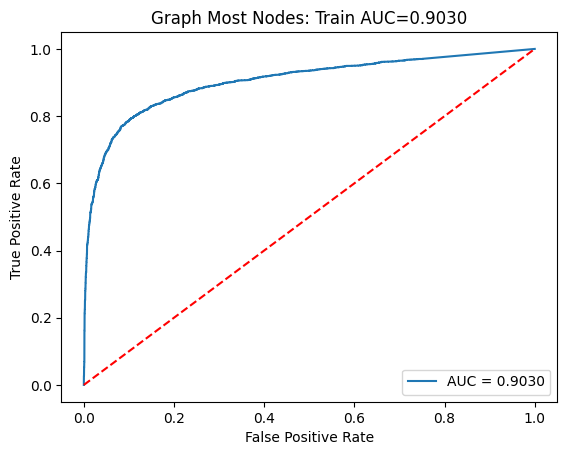

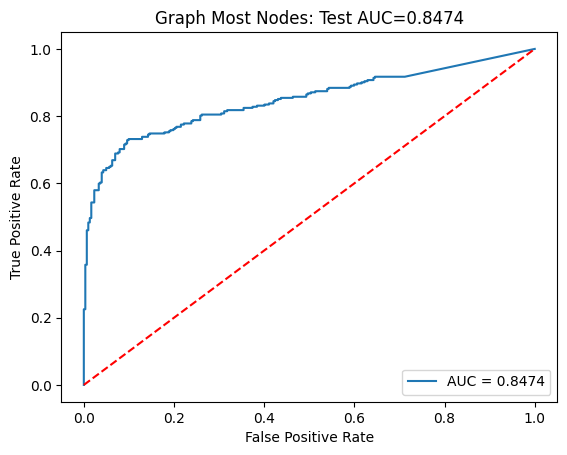

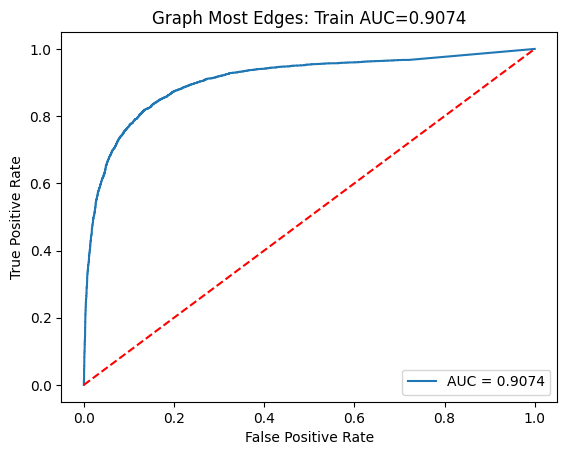

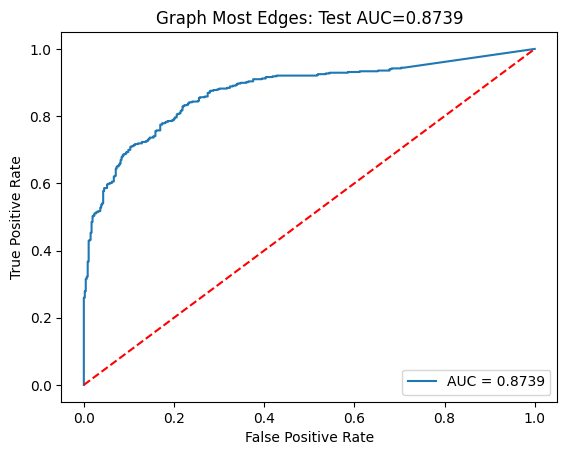

In [ ]:
evaluate_link_prediction_plots(trained_model_nodes, data_nodes, train_neg_edge_index=None, add_title='Most Nodes')

evaluate_link_prediction_plots(trained_model_edges, data_edges, train_neg_edge_index=None, add_title='Most Edges')

## Interpretation of the Results

For the graph with the most nodes:
- Train AUC ~0.9030 suggests the model has learned to distinguish positive (existing) edges from negative (nonexistent) edges with reasonably high accuracy on the training set.
- Test AUC ~0.8474 is somewhat lower but still good. This drop indicates that, while the model generalizes to unseen edges, there is a moderate gap compared to training performance.

For the graph with the most edges:
- Train AUC ~0.9074 indicates similarly strong learning on the training subgraph.
- Test AUC ~0.8739 is closer to the training score, suggesting better generalization and a smaller gap between training and testing.

### Key Takeaways
1.	Strong Performance Overall
Both graphs display solid predictive capability, with AUC values above 0.80 in testing. This means the model effectively identifies likely connections between nodes.
2.	Generalization vs. Overfitting
- In the graph with more nodes, the gap between train (0.9030) and test (0.8474) is somewhat bigger, pointing to mild overfitting or complexity.
- In the graph with more edges, the gap is smaller (0.9074 vs. 0.8739), indicating the model generalizes better in that setting.
3.	Contextual Differences
- The graph with more nodes may have sparse features or structural variability that slightly hinders generalization.
- The graph with more edges may be more densely connected, allowing the model to learn consistent link patterns that transfer better to test edges.

Overall, both models achieve strong link-prediction performance, with the one trained on the denser graph displaying a slightly narrower train-vs-test gap.